В данной работе проведено сравнение реализаций алгоритма WA* с различными значениями фактора субоптимальности. В качестве задачи использовалось нахождение пути на карте с препятствиями, с возможностью хождения по диагонали, без срезания углов. В алгоритме использовалась octile эвристика. Значениями параметра w являются 1.0 (классический A*), 1.05, 1.1, 1.5, 2.0, 3.0, 5.0, 10.0.

Для тестирования использовались задания из коллекции MovingAI. В качестве карт были выбраны карта из игры Baldurs Gate II (AR0205SR.map), лабиринт (maze512-4-6.map) и карта Милана (Milan_1_512.map). Они обладают разной топологией. Лабиринт предполагает нахождение единственного пути до цели, пространство замкнуто. Карта Милана наоборот, свободная, но с достаточным количеством препятствий. Она предполагает наличие большого числа путей до цели. Карта из Baldurs Gate II представляет собой нечто среднее -- пространство замкнутое, но до цели зачастую может быть несколько путей через центральную часть карты. Данные карты использовались в прошлой лабораторной работе по бенчмаркам эвристик A*, и алгоритмы показывали на них различные результаты, что также говорит о их различиях в топологии.

Из каждой карты выбиралось 100 заданий случайным образом. Таким образом, алгоритм должен был решать как простые, так и сложные задания. Внутри одной карты задания были одинаковы для всех алгоритмов, т.е. сначала случайно выбирались задания, а потом на них запускались все вариации алгоритма.

В качестве отслеживаемых параметров были выбраны время работы программы, число раскрытий вершин (эквивалент времени работы) и размер дерева на момент окончания алгоритма (эквивалент количества используемой памяти). Поскольку алгоритм WA* в общем случае предоставляет субоптимальное решение, то будем также отслеживать длину пути, которую нам выдал алгоритм. Будем также следить, нашёл ли алгоритм путь до цели (чтобы не учитывать длину пути там, где алгоритм не нашёл этот самый путь). Ожидаем, что все алгоритмы будут находить путь в 100% случаев (так устроены задания в используемой коллекции карт).

В следующих нескольких ячейках представлена реализация алгоритма WA*.

In [155]:
import random
import traceback
from heapq import heappop, heappush
from pathlib import Path
from textwrap import dedent
from typing import Callable, Dict, Iterable, List, Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import time

np.random.seed(42)

In [156]:
class Map:
    """
    Represents a square grid environment for our moving agent.

    Attributes
    ----------
    _width : int
        The number of columns in the grid.

    _height : int
        The number of rows in the grid.

    _cells : np.ndarray
        A binary matrix representing the grid where 0 represents a traversable cell, and 1 represents a blocked cell.
    """

    def __init__(self, cells: npt.NDArray):
        """
        Initializes the map using a 2D array of cells.

        Parameters
        ----------
        cells : np.ndarray
            A binary matrix representing the grid. 0 indicates a traversable cell, and 1 indicates a blocked cell.
        """
        self._width = cells.shape[1]
        self._height = cells.shape[0]
        self._cells = cells

    def in_bounds(self, i: int, j: int) -> bool:
        """
        Checks if the cell (i, j) is within the grid boundaries.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        bool
            True if the cell is inside the grid, False otherwise.
        """
        return 0 <= j < self._width and 0 <= i < self._height

    def traversable(self, i: int, j: int) -> bool:
        """
        Checks if the cell (i, j) is not an obstacle.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        bool
            True if the cell is traversable, False if it's blocked.
        """
        return not self._cells[i, j]

    def get_neighbors(self, i: int, j: int) -> List[Tuple[int, int]]:
        """
        Gets a list of neighboring cells as (i, j) tuples.
        Assumes that the grid is 4-connected, allowing moves only in cardinal directions.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        neighbors : List[Tuple[int, int]]
            List of neighboring cells.
        """
        neighbors = []
        delta = ((0, 1), (1, 0), (0, -1), (-1, 0), (1, -1), (1, 1), (-1, 1), (-1, -1))
        for dx, dy in delta:
            ni, nj = i + dx, j + dy
            if self.in_bounds(ni, nj) and self.traversable(ni, nj):
                if dx * dy != 0:
                    if (self.in_bounds(i, j + dy) and not self.traversable(i, j + dy)) or (self.in_bounds(i + dx, j) and not self.traversable(i + dx, j)):
                        continue
                neighbors.append((ni, nj))
        return neighbors

    def get_size(self) -> Tuple[int, int]:
        """
        Returns the size of the grid in cells.

        Returns
        ----------
        (height, width) : Tuple[int, int]
            Number of rows and columns in the grid.
        """
        return self._height, self._width

In [157]:
def convert_string_to_cells(cell_str: str) -> npt.NDArray:
    """
    Converts a string representation of a grid map, with '#' for obstacles and '.' for free cells, into a binary matrix.

    Parameters
    ----------
    cell_str : str
        String containing grid map information ('@' for obstacles and '.' for free cells).

    Returns
    ----------
    cells : np.ndarray
        Binary matrix representing the grid map.
    """
    lines = cell_str.replace(" ", "").split("\n")

    cells = np.array(
        [[1 if char == "@" else 0 for char in line] for line in lines if line],
        dtype=np.int8,
    )
    return cells

In [158]:
def read_map_from_file(filename: str) -> npt.NDArray:
    f = open(filename)
    data = f.readlines()
    map = data[4:] # First four elements are type, width, height and "map" string
    return convert_string_to_cells("".join(map))

In [159]:
def compute_cost(i1: int, j1: int, i2: int, j2: int) -> Union[int, float]:
    """
    Computes the cost of simple moves between cells (i1, j1) and (i2, j2).

    Parameters
    ----------
    i1 : int
        Row number of the first cell in the grid.
    j1 : int
        Column number of the first cell in the grid.
    i2 : int
        Row number of the second cell in the grid.
    j2 : int
        Column number of the second cell in the grid.

    Returns
    ----------
    int | float
        Cost of the move between cells.

    Raises
    ----------
    ValueError
        If trying to compute the cost of a non-supported move (only cardinal moves are supported).
    """
    if abs(i1 - i2) + abs(j1 - j2) == 1:  # Cardinal move
        return 1
    elif abs(i1 - i2) == 1 and abs(j1 - j2) == 1: # Diagonal move
        return 2 ** 0.5
    else:
        raise ValueError("Trying to compute the cost of a non-supported move! ONLY one-square moves are supported.")

In [160]:
class Node:
    """
    Represents a search node.

    Attributes
    ----------
    i : int
        Row coordinate of the corresponding grid element.
    j : int
        Column coordinate of the corresponding grid element.
    g : float | int
        g-value of the node.
    h : float | int
        h-value of the node
    f : float | int
        f-value of the node
    parent : Node
        Pointer to the parent node.
    """

    def __init__(
        self,
        i: int,
        j: int,
        g: Union[float, int] = 0,
        h: Union[float, int] = 0,
        f: Optional[Union[float, int]] = None,
        w: Union[float, int] = 1,
        parent: "Node" = None,
    ):
        """
        Initializes a search node.

        Parameters
        ----------
        i : int
            Row coordinate of the corresponding grid element.
        j : int
            Column coordinate of the corresponding grid element.
        g : float | int
            g-value of the node.
        h : float | int
            h-value of the node (always 0 for Dijkstra).
        f : float | int
            f-value of the node (always equal to g-value for Dijkstra).
        w : float | int
            weight of heuristic (1 for vanila A*)
        parent : Node
            Pointer to the parent node.
        """
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        self.w = w
        if f is None:
            self.f = self.g + w * h
        else:
            self.f = f
        self.parent = parent

    def __eq__(self, other):
        """
        Checks if two search nodes are the same, which is needed to detect duplicates in the search tree.
        """
        return self.i == other.i and self.j == other.j

    def __hash__(self):
        """
        Makes the Node object hashable, allowing it to be used in sets/dictionaries.
        """
        return hash((self.i, self.j))

    def __lt__(self, other):
        """
        Compares the keys (i.e., the f-values) of two nodes, needed for sorting/extracting the best element from OPEN.
        """
        return self.f < other.f

In [161]:
class SearchTreePQD:
    """
    SearchTree using a priority queue for OPEN and a dictionary for CLOSED.
    """

    def __init__(self):
        self._open = []  # Priority queue for nodes in OPEN
        self._closed = {}  # Dictionary for nodes in CLOSED (expanded nodes)
        self._enc_open_dublicates = 0  # Number of dublicates encountered in OPEN

    def __len__(self) -> int:
        """
        Returns the size of the search tree. Useful for assessing the memory
        footprint of the algorithm, especially at the final iteration.
        """
        return len(self._open) + len(self._closed)

    def open_is_empty(self) -> bool:
        """
        Checks if OPEN is empty.
        If true, the main search loop should be interrupted.
        """
        return len(self._open) == 0

    def add_to_open(self, item: Node):
        """
        Adds a node to the search tree, specifically to OPEN. This node is either
        entirely new or a duplicate of an existing node in OPEN.
        This implementation detects duplicates lazily; thus, nodes are added to
        OPEN without initial duplicate checks.
        """
        heappush(self._open, item)

    def get_best_node_from_open(self) -> Optional[Node]:
        """
        Retrieves the best node from OPEN, defined by the minimum key.
        This node will then be expanded in the main search loop.

        Duplicates are managed here. If a node has been expanded previously
        (and is in CLOSED), it's skipped and the next best node is considered.

        Returns None if OPEN is empty.
        """
        while not self.open_is_empty():
            item = heappop(self._open)
            if not self.was_expanded(item):
                return item
            self._enc_open_dublicates += 1
        return None

    def add_to_closed(self, item: Node):
        """
        Adds a node to the CLOSED dictionary.
        """
        self._closed[item] = item

    def was_expanded(self, item: Node) -> bool:
        """
        Checks if a node has been previously expanded.
        """
        return item in self._closed

    @property
    def opened(self):
        return self._open

    @property
    def expanded(self):
        return self._closed.values()

    @property
    def number_of_open_dublicates(self):
        return self._enc_open_dublicates

In [162]:
def weight_astar(
    task_map: Map,
    start_i: int,
    start_j: int,
    goal_i: int,
    goal_j: int,
    heuristic_func: Callable,
    search_tree: Type[SearchTreePQD],
    w: Union[float, int]
) -> Tuple[bool, int, int, float]:
    """
    Implements the A* search algorithm.

    Parameters
    ----------
    task_map : Map
        The grid or map being searched.
    start_i, start_j : int, int
        Starting coordinates.
    goal_i, goal_j : int, int
        Goal coordinates.
    heuristic_func : Callable
        Heuristic function for estimating the distance from a node to the goal.
    search_tree : Type[SearchTreePQD]
        The search tree to use.
    w : weight of heuristic

    Returns
    -------
    Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]
        Tuple containing:
        - A boolean indicating if a path was found.
        - The last node in the found path or None.
        - Number of algorithm iterations.
        - Size of the resultant search tree.
        - result path
    """
    ast = search_tree()
    steps = 0

    start_node = Node(start_i, start_j, g=0, h=heuristic_func(start_i, start_j, goal_i, goal_j), w=w)
    ast.add_to_open(start_node)


    while not ast.open_is_empty():
        node = ast.get_best_node_from_open()
        if node is None:
            return False, steps, len(ast), 0
        if node.i == goal_i and node.j == goal_j:
            return True, steps, len(ast), node.g
        ast.add_to_closed(node)
        successors = task_map.get_neighbors(node.i, node.j)
        for successor in successors:
            new_g = node.g + compute_cost(node.i, node.j, successor[0], successor[1])
            next_node = Node(successor[0], successor[1], g=new_g, h=heuristic_func(successor[0], successor[1], goal_i, goal_j), w=w, parent=node)
            if not ast.was_expanded(next_node):
                ast.add_to_open(next_node)
        steps += 1

    return False, steps, len(ast), 0

In [163]:
def octile(x1: int, y1: int, x2: int, y2: int) -> float:
    dx = abs(x1 - x2)
    dy = abs(y1 - y2)
    return min(dx, dy) * 2 ** 0.5 + abs(dx - dy)

Далее представлена реализация тестирования.

In [164]:
class Coord:
    def __init__(self, x, y):
        self.x = int(x)
        self.y = int(y)
    
    def __str__(self):
        return f"({self.x}, {self.y})"

In [165]:
def get_random_tasks(scen_filename: str) -> List[Tuple[Coord, Coord, float]]:
    f = open(scen_filename)
    data = f.readlines()[1:] # First string is file version
    n = len(data)
    tasks_cnt = 100
    indices = np.random.randint(0, n, size=tasks_cnt)
    tasks = []
    for index in indices:
        row = data[index]
        bucket, map_name, w, h, start_x, start_y, end_x, end_y, length = row.split()
        tasks.append((Coord(start_y, start_x), Coord(end_y, end_x), float(length)))
    return tasks

In [166]:
def scen_test(
        w: Union[float, int],
        map: Map, 
        tasks: List[Tuple[Coord, Coord, float]]
    ) -> Tuple[List[int], List[int], List[int], List[float], List[float]]:
    
    list_steps = []
    list_found = []
    list_length = []
    list_time = []
    list_paths = []
    runs = 8
    for task in tasks:
        start_time = time.time()
        for _ in range(runs):
            found, cur_steps, cur_length, path_length = weight_astar(map, task[0].x, task[0].y, task[1].x, task[1].y, octile, SearchTreePQD, w)
        finish_time = time.time()
        list_steps.append(cur_steps)
        list_length.append(cur_length)
        list_time.append((finish_time - start_time) / runs)
        list_found.append(int(found))
        list_paths.append(path_length)
    return list_found, list_steps, list_length, list_time, list_paths

In [167]:
def map_test(
        weights: List[Union[float, int]],
        map: Map,
        scen_path: str
    ) -> Tuple[List[List[int]], List[List[int]], List[List[int]], List[List[float]], List[List[float]]]:

    list_found, list_steps, list_length, list_time, list_paths = [], [], [], [], []
    tasks = get_random_tasks(scen_path)
    for i in range(len(weights)):
        w = weights[i]
        all_found, all_steps, all_length, all_time, all_paths = scen_test(w, map, tasks)
        list_found.append(all_found)
        list_steps.append(all_steps)
        list_length.append(all_length)
        list_time.append(all_time)
        list_paths.append(all_paths)
    return list_found, list_steps, list_length, list_time, list_paths

In [168]:
def massive_test():
    maps_dir = "Maps"
    maps_names = ["AR0205SR.map", "maze512-4-6.map", "Milan_1_512.map"]
    scens_dir = "Scens"
    scens_names = ["AR0205SR.map.scen", "maze512-4-6.map.scen", "Milan_1_512.map.scen"]
    weights = [1.0, 1.05, 1.1, 1.5, 2.0, 3.0, 5.0, 10.0]
    algorithms_names = [f"WA*_(w={w})" for w in weights]
    algorithms_names[0] = "Vanila_A*"
    output_file_name = "output.txt"
    f = open(output_file_name, "w")
    for i in range(len(maps_names)):
        map_path = Path(maps_dir) / Path(maps_names[i])
        scen_path = Path(scens_dir) / Path(scens_names[i])
        map = Map(read_map_from_file(map_path))
        list_found, list_steps, list_length, list_time, list_paths = map_test(weights, map, scen_path)
        for j in range(len(list_found)):
            for k in range(len(list_found[0])):
                f.write(f"{k} {maps_names[i]} {algorithms_names[j]} {list_found[j][k]} {list_steps[j][k]} {list_length[j][k]} {list_time[j][k]} {list_paths[j][k]}\n")
    f.close()

In [169]:
massive_test()

В следующих ячейках реализация визуализации данных.

In [170]:
def get_statistics():
    output_file_name = "output.txt"
    f = open(output_file_name)
    data = f.readlines()
    statistics = {}
    for row in data:
        test_num, map_name, algorithm, correctness, steps, length, time, path = row.split()
        if map_name not in statistics:
            statistics[map_name] = {}
        if algorithm not in statistics[map_name]:
            statistics[map_name][algorithm] = {'number of test': [], 'correctness': [], 'steps': [], 'tree size': [], 'time': [], 'path length': []}
        statistics[map_name][algorithm]['correctness'].append(int(correctness))
        statistics[map_name][algorithm]['steps'].append(int(steps))
        statistics[map_name][algorithm]['tree size'].append(int(length))
        statistics[map_name][algorithm]['number of test'].append(int(test_num))
        statistics[map_name][algorithm]['time'].append(float(time))
        statistics[map_name][algorithm]['path length'].append(float(path))
    f.close()
    return statistics

In [171]:
def draw_box_plot(stat_names: List[str], normalize: bool = False):
    all_stat = get_statistics()
    map_names = ['Baldurs Gate II map', 'Maze', 'Milan']
    map_paths = ["AR0205SR.map", "maze512-4-6.map", "Milan_1_512.map"]
    eps = 10 ** -6
    fig, ax = plt.subplots(nrows=len(map_names), ncols=len(stat_names), figsize=(23, 20))
    for i in range(len(map_names)):
        mapname = map_paths[i]
        map_stat = all_stat[mapname]
        labels = list(map_stat.keys())
        # print(map_stat)
        for j in range(len(stat_names)):
            statname = stat_names[j]
            data = [map_stat[alg][statname] for alg in map_stat.keys()]
            yaxis_name = statname
            normalized_yaxis_name = f"normalized {statname}"
            base = data[0]
            normalized_data = [[row[i] / (base[i] + eps) for i in range(len(base))] for row in data[1:]]
            normalized_labels = labels[1:]
            smth = ax[i]
            if len(stat_names) > 1:
                smth = ax[i, j]
            smth.set_title(map_names[i])         
            if normalize:
                smth.set_ylabel(normalized_yaxis_name)
                bplot = smth.boxplot(normalized_data, labels=normalized_labels)
            else:
                smth.set_ylabel(yaxis_name)
                bplot = smth.boxplot(data, labels=labels)
    plt.show()

In [172]:
def draw_hyst():
    all_stat = get_statistics()
    fig, ax = plt.subplots(figsize=(10, 5), layout='constrained')
    map_names = ['Baldurs Gate II map', 'Maze', 'Milan']
    map_paths = ["AR0205SR.map", "maze512-4-6.map", "Milan_1_512.map"]
    weights = [1.0, 1.05, 1.1, 1.5, 2.0, 3.0, 5.0, 10.0]
    alg_names = [f"WA*_(w={w})" for w in weights]
    alg_names[0] = "Vanila_A*"
    x = np.arange(len(map_names))  # the label locations
    width = 0.1  # the width of the bars
    multiplier = 0
    for alg in alg_names:
        data = []
        for map in map_paths:
            data.append(sum(all_stat[map][alg]['correctness']) / len(all_stat[map][alg]['correctness']))
        offset = width * multiplier
        rects = ax.bar(x + offset, data, width, label=alg)
        ax.bar_label(rects, padding=1)
        multiplier += 1
    ax.set_ylabel('part of runs where path was found')
    ax.set_title('Correctness of path found')
    ax.set_xticks(x + width * 3.5, map_names)
    ax.legend(loc='upper left', ncols=2)
    ax.set_ylim(0, 1.5)

    plt.show()

In [188]:
def draw_plot(stat_name: str, weights: List[Union[float, int]]):
    all_stat = get_statistics()
    fig, ax = plt.subplots(figsize=(7, 7))
    map_paths = ["AR0205SR.map", "maze512-4-6.map", "Milan_1_512.map"]
    weights = [1.0] + weights
    alg_names = [f"WA*_(w={w})" for w in weights]
    alg_names[0] = "Vanila_A*"
    vanila_steps = []
    vanila_stats = []
    for map_name in map_paths:
        vanila_steps += all_stat[map_name]['Vanila_A*']['steps']
        vanila_stats += all_stat[map_name]['Vanila_A*'][stat_name]
    for alg in alg_names:
        alg_stat = []
        for map_name in map_paths:
            alg_stat += all_stat[map_name][alg][stat_name]
        alg_stat = [alg_stat[i] / vanila_stats[i] for i in range(len(alg_stat))]
        alg_data = sorted(list(zip(alg_stat, vanila_steps)), key=lambda x: x[1])
        ax.plot(list(map(lambda x: x[1], alg_data)), list(map(lambda x: x[0], alg_data)), label=alg)
    ax.set_xlabel('Vanila_A* steps')
    ax.set_ylabel(f'Normalized algorithm {stat_name}')
    ax.legend()
    plt.show()

In [189]:
def draw_plot_map(stat_name: str, weights: List[Union[float, int]]):
    all_stat = get_statistics()
    fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(20, 20))
    map_paths = ["AR0205SR.map", "maze512-4-6.map", "Milan_1_512.map"]
    weights = [1.0] + weights
    alg_names = [f"WA*_(w={w})" for w in weights]
    alg_names[0] = "Vanila_A*"
    map_names = ['Baldurs Gate II map', 'Maze', 'Milan']
    for i in range(len(map_paths)):
        map_name = map_paths[i]
        vanila_steps = all_stat[map_name]['Vanila_A*']['steps']
        vanila_stat = all_stat[map_name]['Vanila_A*'][stat_name]
        for alg in alg_names:
            alg_stat = all_stat[map_name][alg][stat_name]
            alg_stat = [alg_stat[i] / vanila_stat[i] for i in range(len(alg_stat))]
            alg_data = sorted(list(zip(alg_stat, vanila_steps)), key=lambda x: x[1])
            ax[i].plot(list(map(lambda x: x[1], alg_data)), list(map(lambda x: x[0], alg_data)), label=alg)
        ax[i].set_xlabel('Vanila_A* steps')
        ax[i].set_ylabel(f'Normalized algorithm {stat_name}')
        ax[i].legend()
        ax[i].set_title(map_names[i])
    plt.show()

In [232]:
def draw_points():
    all_stat = get_statistics()
    fig, ax = plt.subplots()
    map_paths = ["AR0205SR.map", "maze512-4-6.map", "Milan_1_512.map"]
    weights = [1.0, 1.05, 1.1, 1.5, 2.0, 3.0, 5.0, 10.0]
    alg_names = [f"WA*_(w={w})" for w in weights]
    alg_names[0] = "Vanila_A*"
    vanila_steps = []
    vanila_length = []
    for map_name in map_paths:
        vanila_steps += all_stat[map_name]['Vanila_A*']['steps']
        vanila_length += all_stat[map_name]['Vanila_A*']['path length']
    for i in range(len(alg_names)):
        alg = alg_names[i]
        alg_steps = []
        alg_length = []
        for map_name in map_paths:
            alg_steps += all_stat[map_name][alg]['steps']
            alg_length += all_stat[map_name][alg]['path length']
        x, y = (np.array(alg_steps) / np.array(vanila_steps)).mean(), (np.array(alg_length) / np.array(vanila_length)).mean()
        ax.plot(x, y, 'ro')
        ax.annotate(weights[i], xy=(x, y), xycoords='data', xytext=(1.5, 1.5), textcoords='offset points')
    ax.set_xlabel('Average steps')
    ax.set_ylabel('Average path length')
    ax.set_title('Average characterisrics')
    plt.show()
        

In [230]:
def draw_map_points():
    all_stat = get_statistics()
    fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(10, 15))
    map_paths = ["AR0205SR.map", "maze512-4-6.map", "Milan_1_512.map"]
    weights = [1.0, 1.05, 1.1, 1.5, 2.0, 3.0, 5.0, 10.0]
    alg_names = [f"WA*_(w={w})" for w in weights]
    alg_names[0] = "Vanila_A*"
    map_names = ['Baldurs Gate II map', 'Maze', 'Milan']
    for i in range(len(map_paths)):
        map_name = map_paths[i]
        vanila_steps = np.array(all_stat[map_name]['Vanila_A*']['steps'])
        vanila_paths = np.array(all_stat[map_name]['Vanila_A*']['path length'])
        for j in range(len(alg_names)):
            alg = alg_names[j]
            alg_paths = np.array(all_stat[map_name][alg]['path length'])
            alg_steps = np.array(all_stat[map_name][alg]['steps'])
            x, y = (alg_steps / vanila_steps).mean(), (alg_paths / vanila_paths).mean() 
            ax[i].plot(x, y, 'ro')
            ax[i].annotate(weights[j], xy=(x, y), xycoords='data', xytext=(1.5, 1.5), textcoords='offset points')
        ax[i].set_xlabel('Average steps')
        ax[i].set_ylabel('Average path length')
        ax[i].set_title(map_names[i])
    plt.show()

Перейдём к графикам. Для начала посмотрим, все ли алгоритмы нашли пути до цели. Это скорее необходимо как косвенная проверка, что наши алгоритмы работают корректно. Как видим, все алгоритмы нашли путь в каждом из случаев.

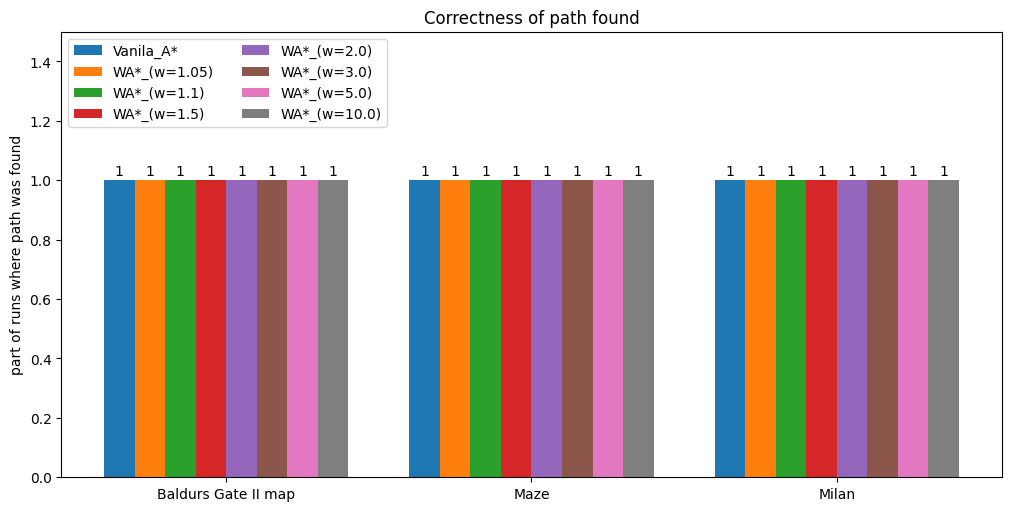

In [175]:
draw_hyst()

Перейдём к более интересным метрикам. В этой и нескольких следующих секциях представлены графики вида box-whisker plot. В каждой секции 3 строчки, каждая из которых отвечает за свою карту. Число столбцов соответствует числу метрик в данной секции. По оси X отложены рассматриваемые алгоритмы, по оси Y - результаты метрик. Дополнительно, название карты является заголовком графика, рассматриваемая метрика указана в наименовании оси Y.

Начнём с числа шагов и времени работы.

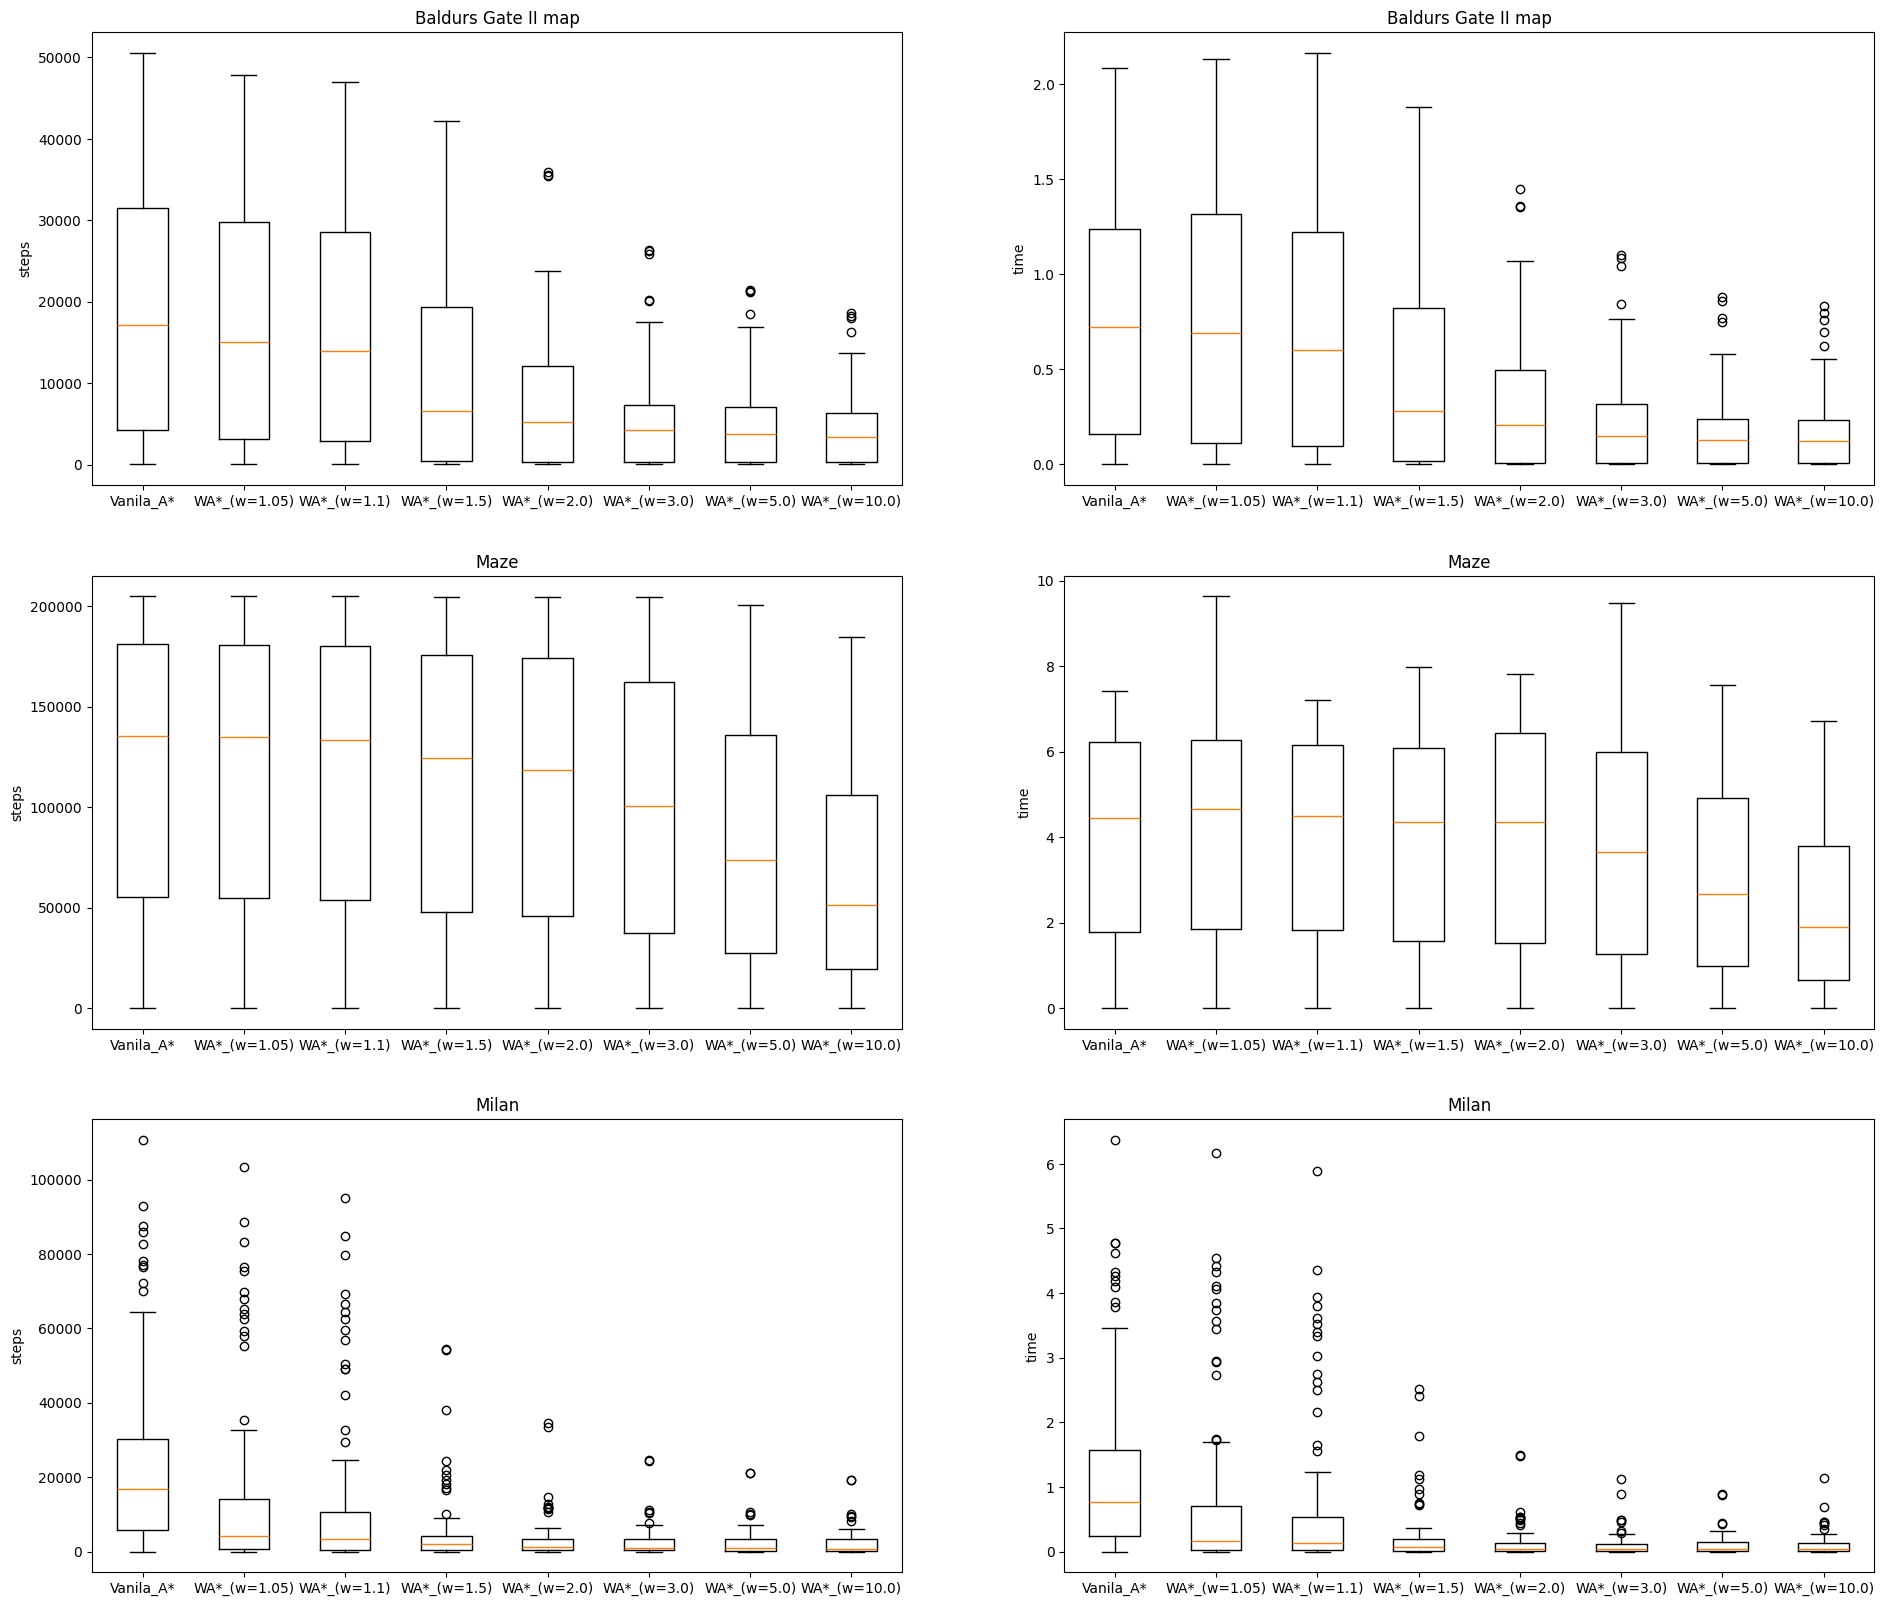

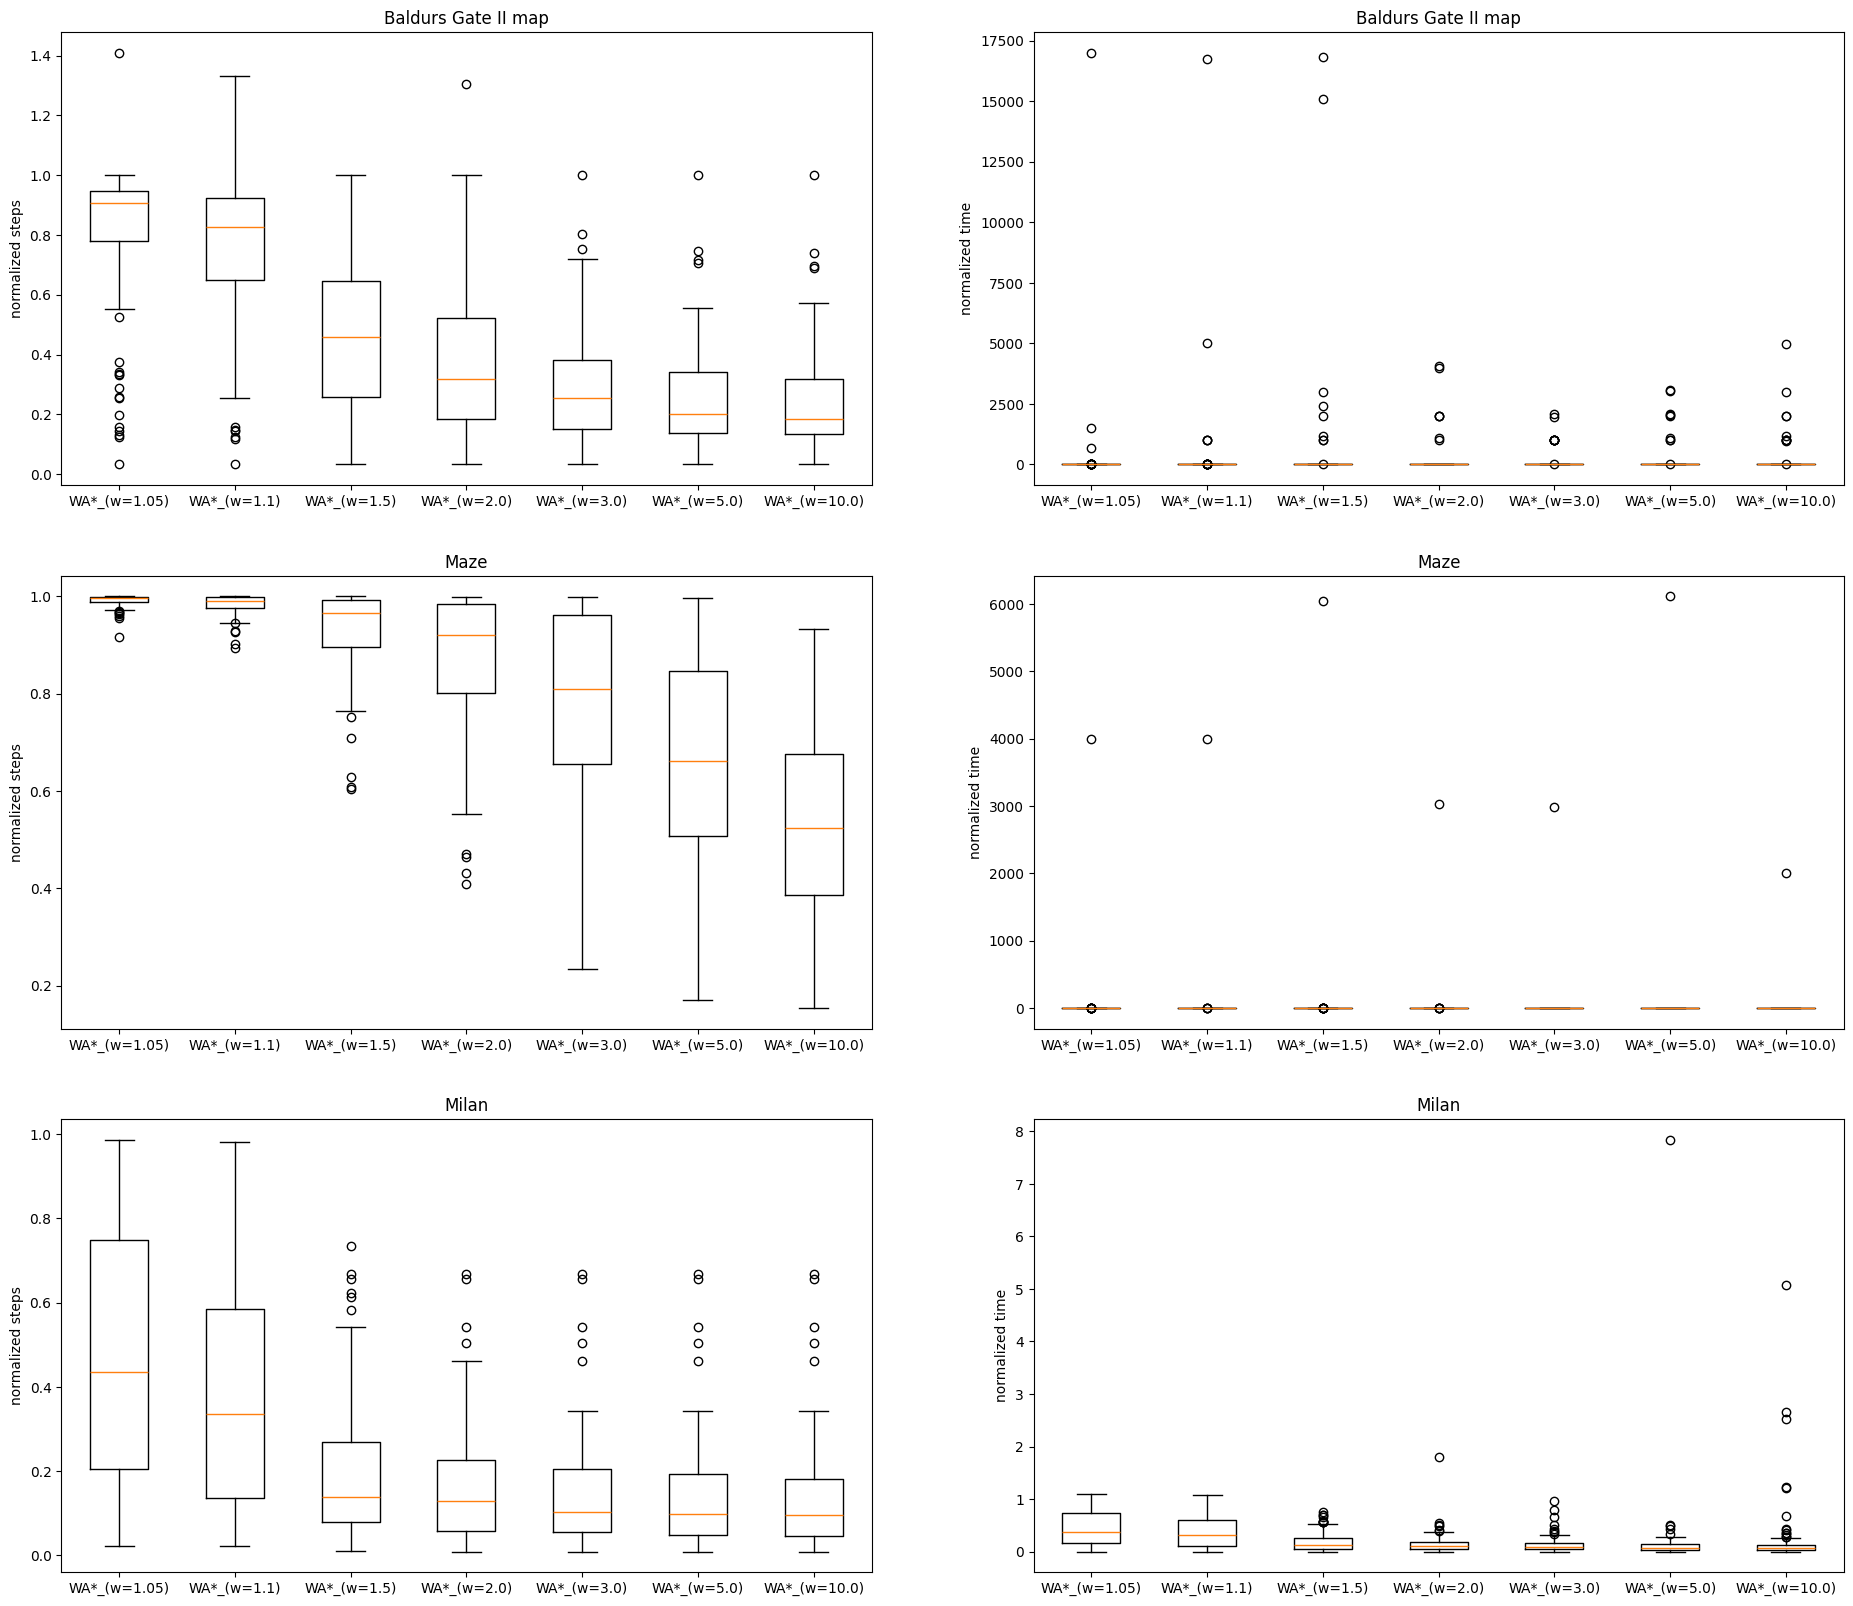

In [176]:
draw_box_plot(['steps', 'time'])
draw_box_plot(['steps', 'time'], True)

Теперь посмотрим на найденную длину пути. Здесь логично смотреть именно на нормализованные значения, т.к. нам нужно отслеживать, во сколько раз выросла длина пути, при разных значениях параметра w. Для наглядности, в левом столбце указано число шагов алгоритма (как оценки времени работы). Соответственно, в правом столбце указано распределение отношения длины пути, найденного алгоритмом, к длине пути, найденного обычным A*.

Можно заметить, что на карте лабиринта самая маленькая дисперсия результатов. Это происходит потому, что в лабиринте почти нет возможности найти несколько значительно различающихся путей. По всей видимости, увеличение длины пути происходит за счёт частых переходов от стенки к стенке лабиринта. Поэтому здесь самый маленький разброс (нельзя взять кардинально неправильный путь). А из-за того, что эвристика в лабиринте работает плохо, если мы ей сильно доверяем (т.е. значение w большое), мы будем часто ошибаться. Поэтому довольно часто находить путь той же длины, что и A* способны только реализации с маленькими значениями параметра w (w = 1.05 и w = 1.1).

С другой стороны, на карте Милана заметно ниже средняя длина получаемого пути при больших значениях параметра w, по сравнению с другими картами. Поскольку на карте много свободного пространства, эвристика работает хорошо. И значит в большинстве случаев можно ей доверять сильнее, чем обычно. Так что ошибка накапливается не так сильно, как на других картах, где эвристика работает хуже. Тем не менее, нам может повезти, и нам не придётся обходить препятствия вообще, а может придётся совершить много обходов. Карта способна генерировать оба этих случая. И в первом варианте мы найдём путь такой же, как у A*, а во втором - значительно больший. Поэтому, на этой карте достаточно большой разброс.

На карте Baldurs Gate II большой разброс (сопоставимый с картой Милана) и самые большие средние длины путей. Разброс большой, т.к. и карта Милана, данная карта способна генерировать задания как без препятствий на пути, так и с ними. И в зависимости от этого, результат будет ближе или дальше по отношению к результату алгоритма A*. Но т.к. здесь нужно не столько обходить препятствия, сколько выбрать правильное направление движения, цена ошибки выше, чем на других картах. Поэтому среднее расстояние больше.

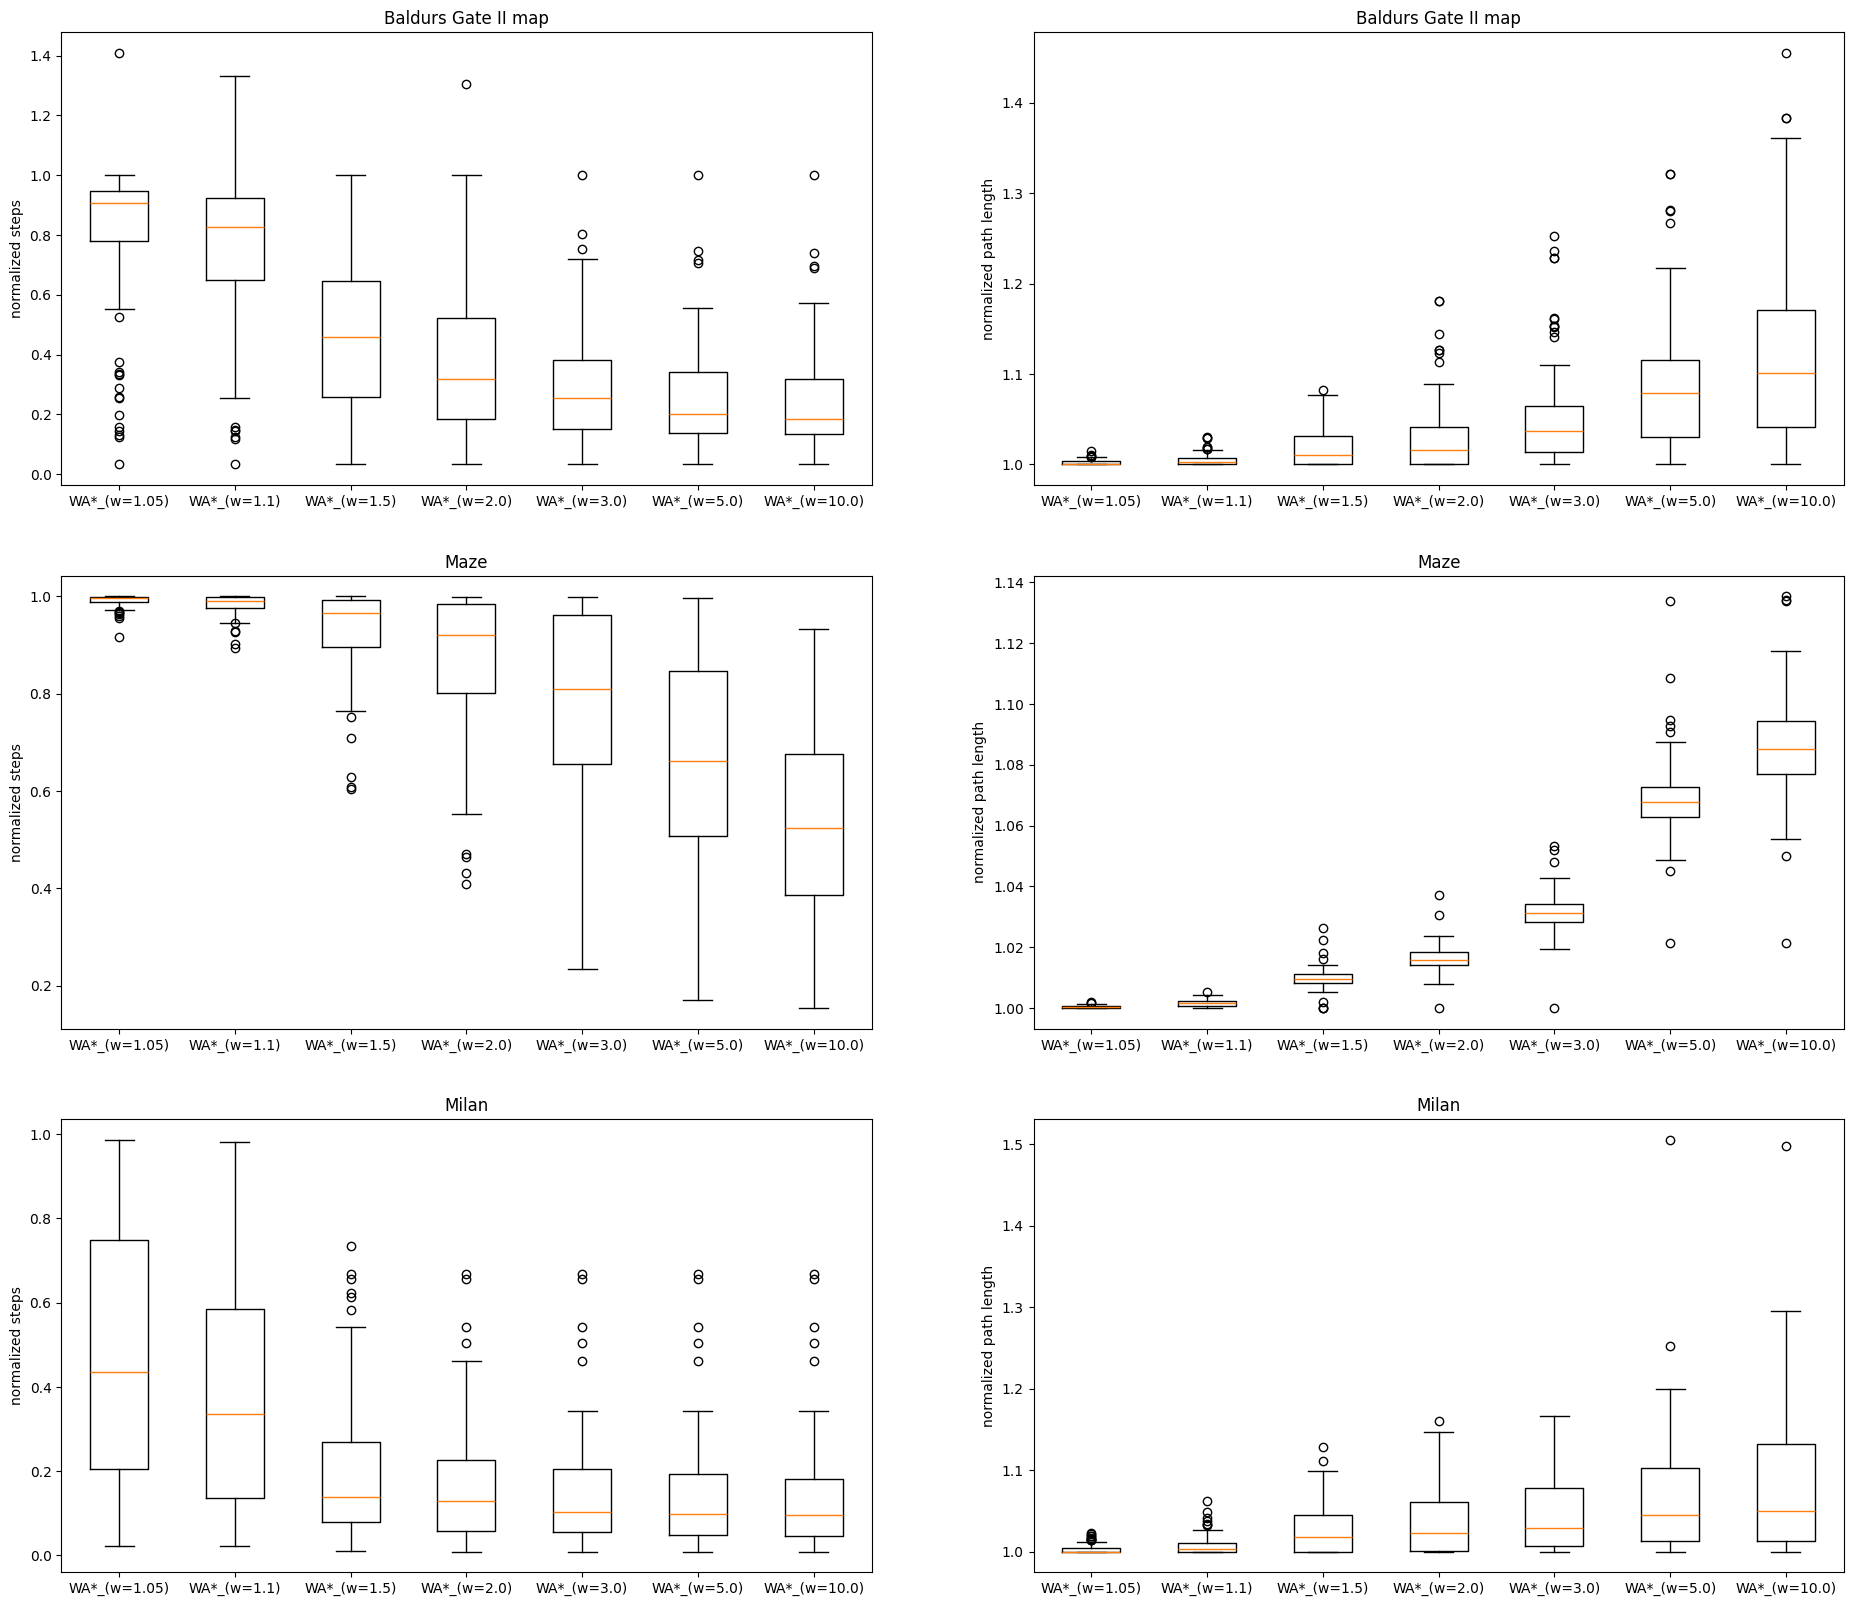

In [177]:
draw_box_plot(['steps', 'path length'], True)

Теперь посмотрим на размер дерева (аналог затраченной памяти). В первой группе графиков он представлен в суммарном числе вершин в списках Open и Closed. Во второй группе он нормализован относительно размера дерева алгоритма A*.

Общая ситуация аналогична ситуации с числом шагов алгоритма. Как и ожидалось, мы видим понижение размера дерева с увеличением параметра w.

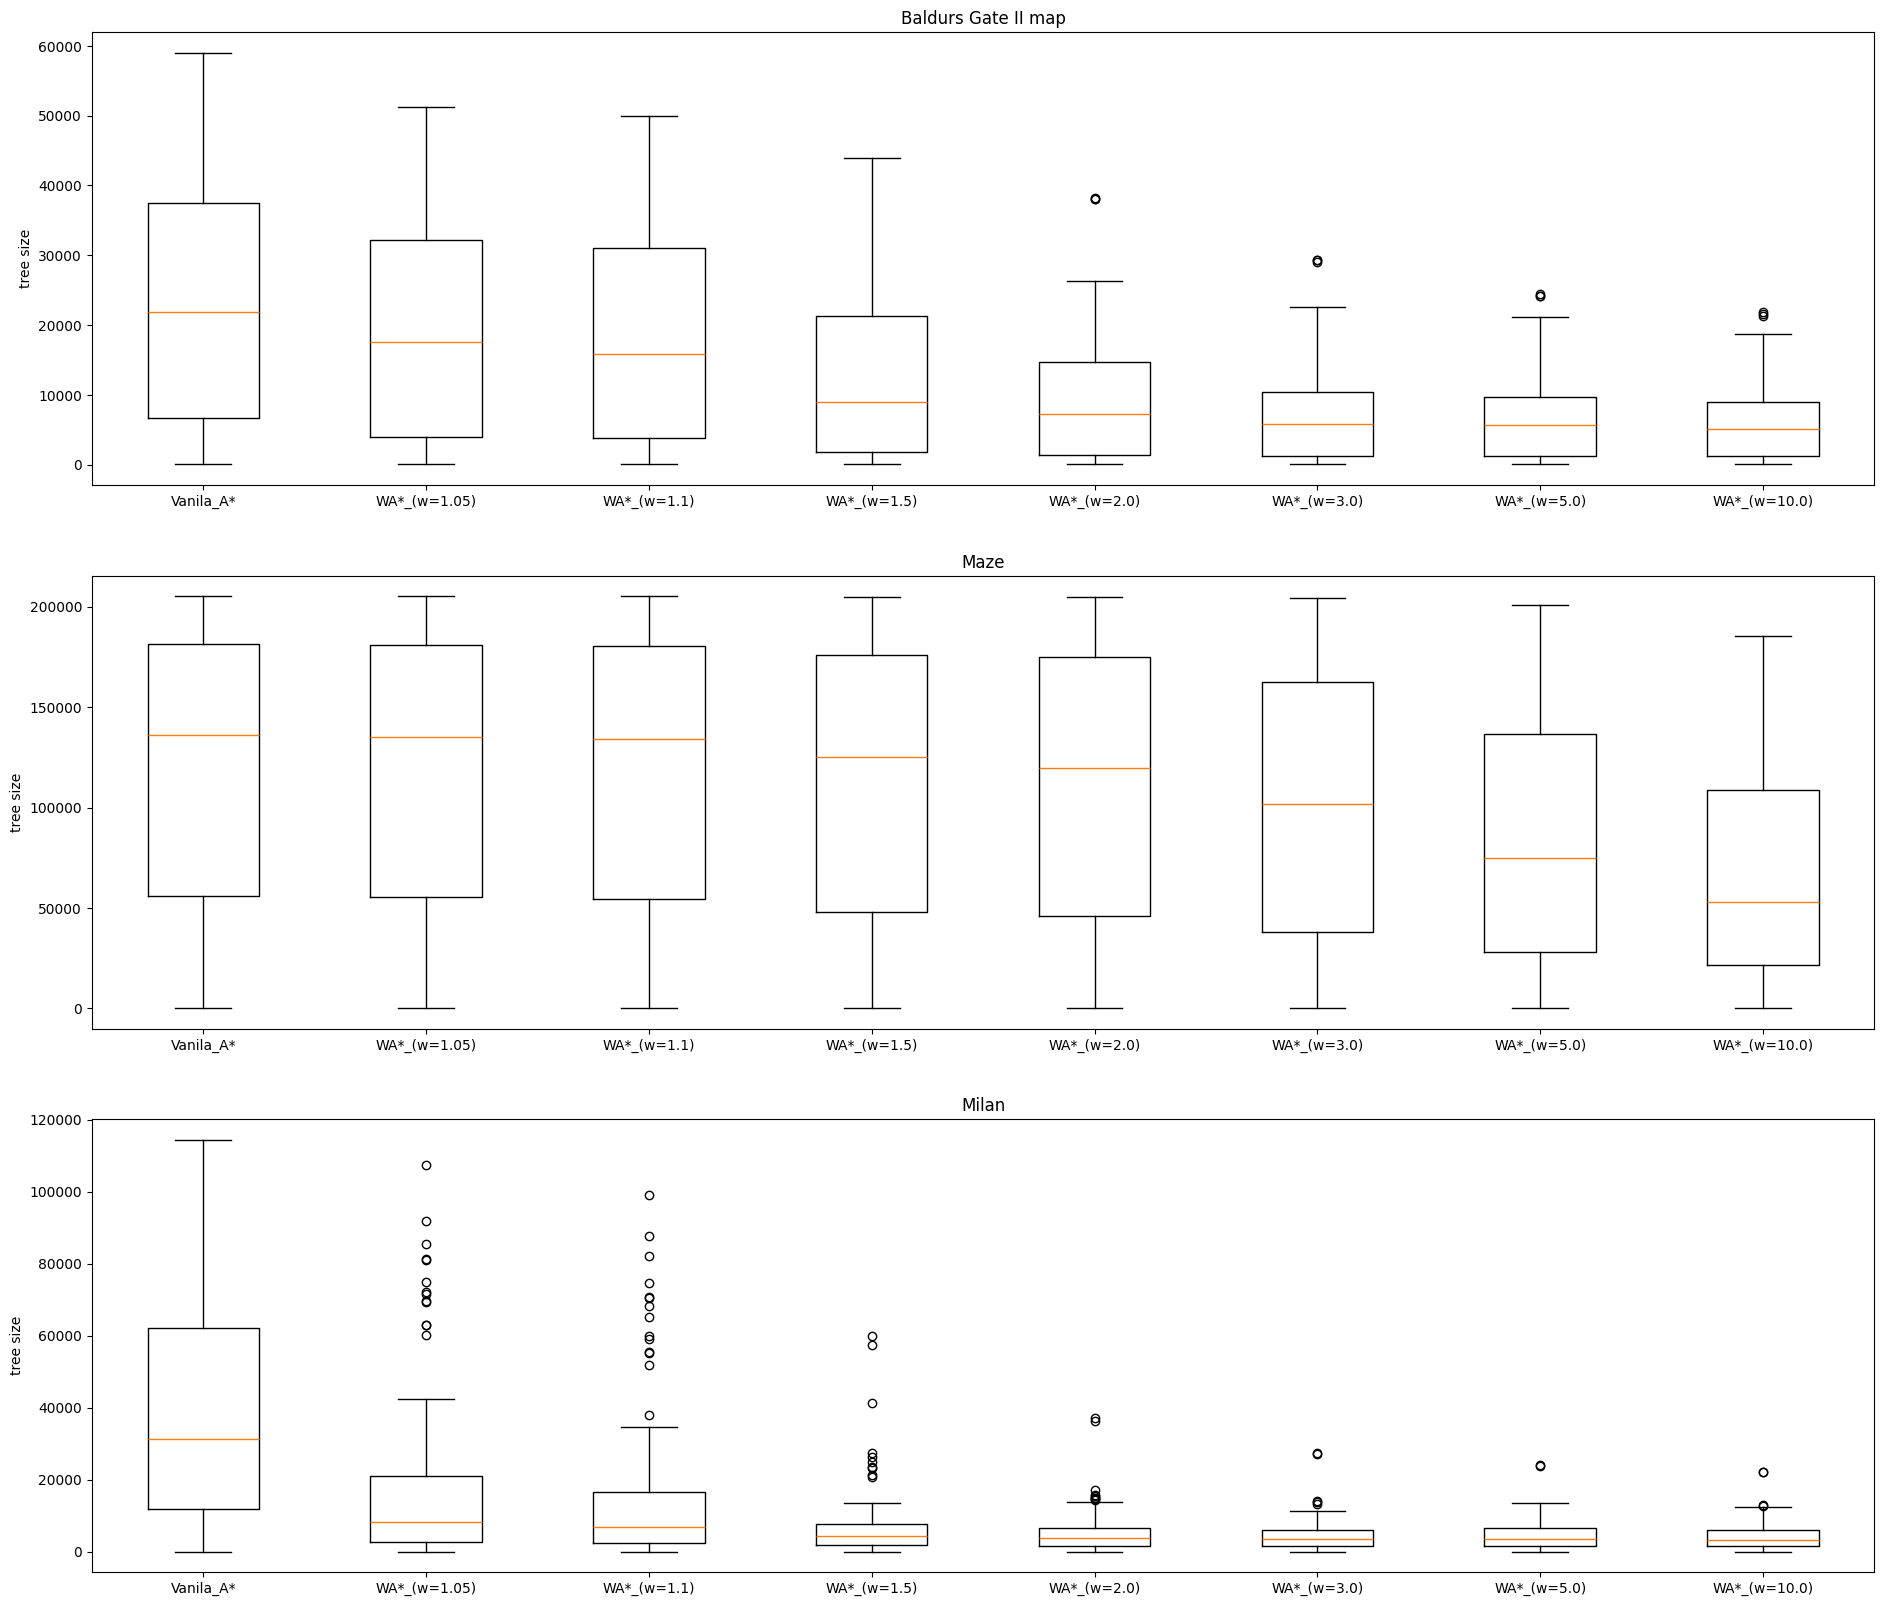

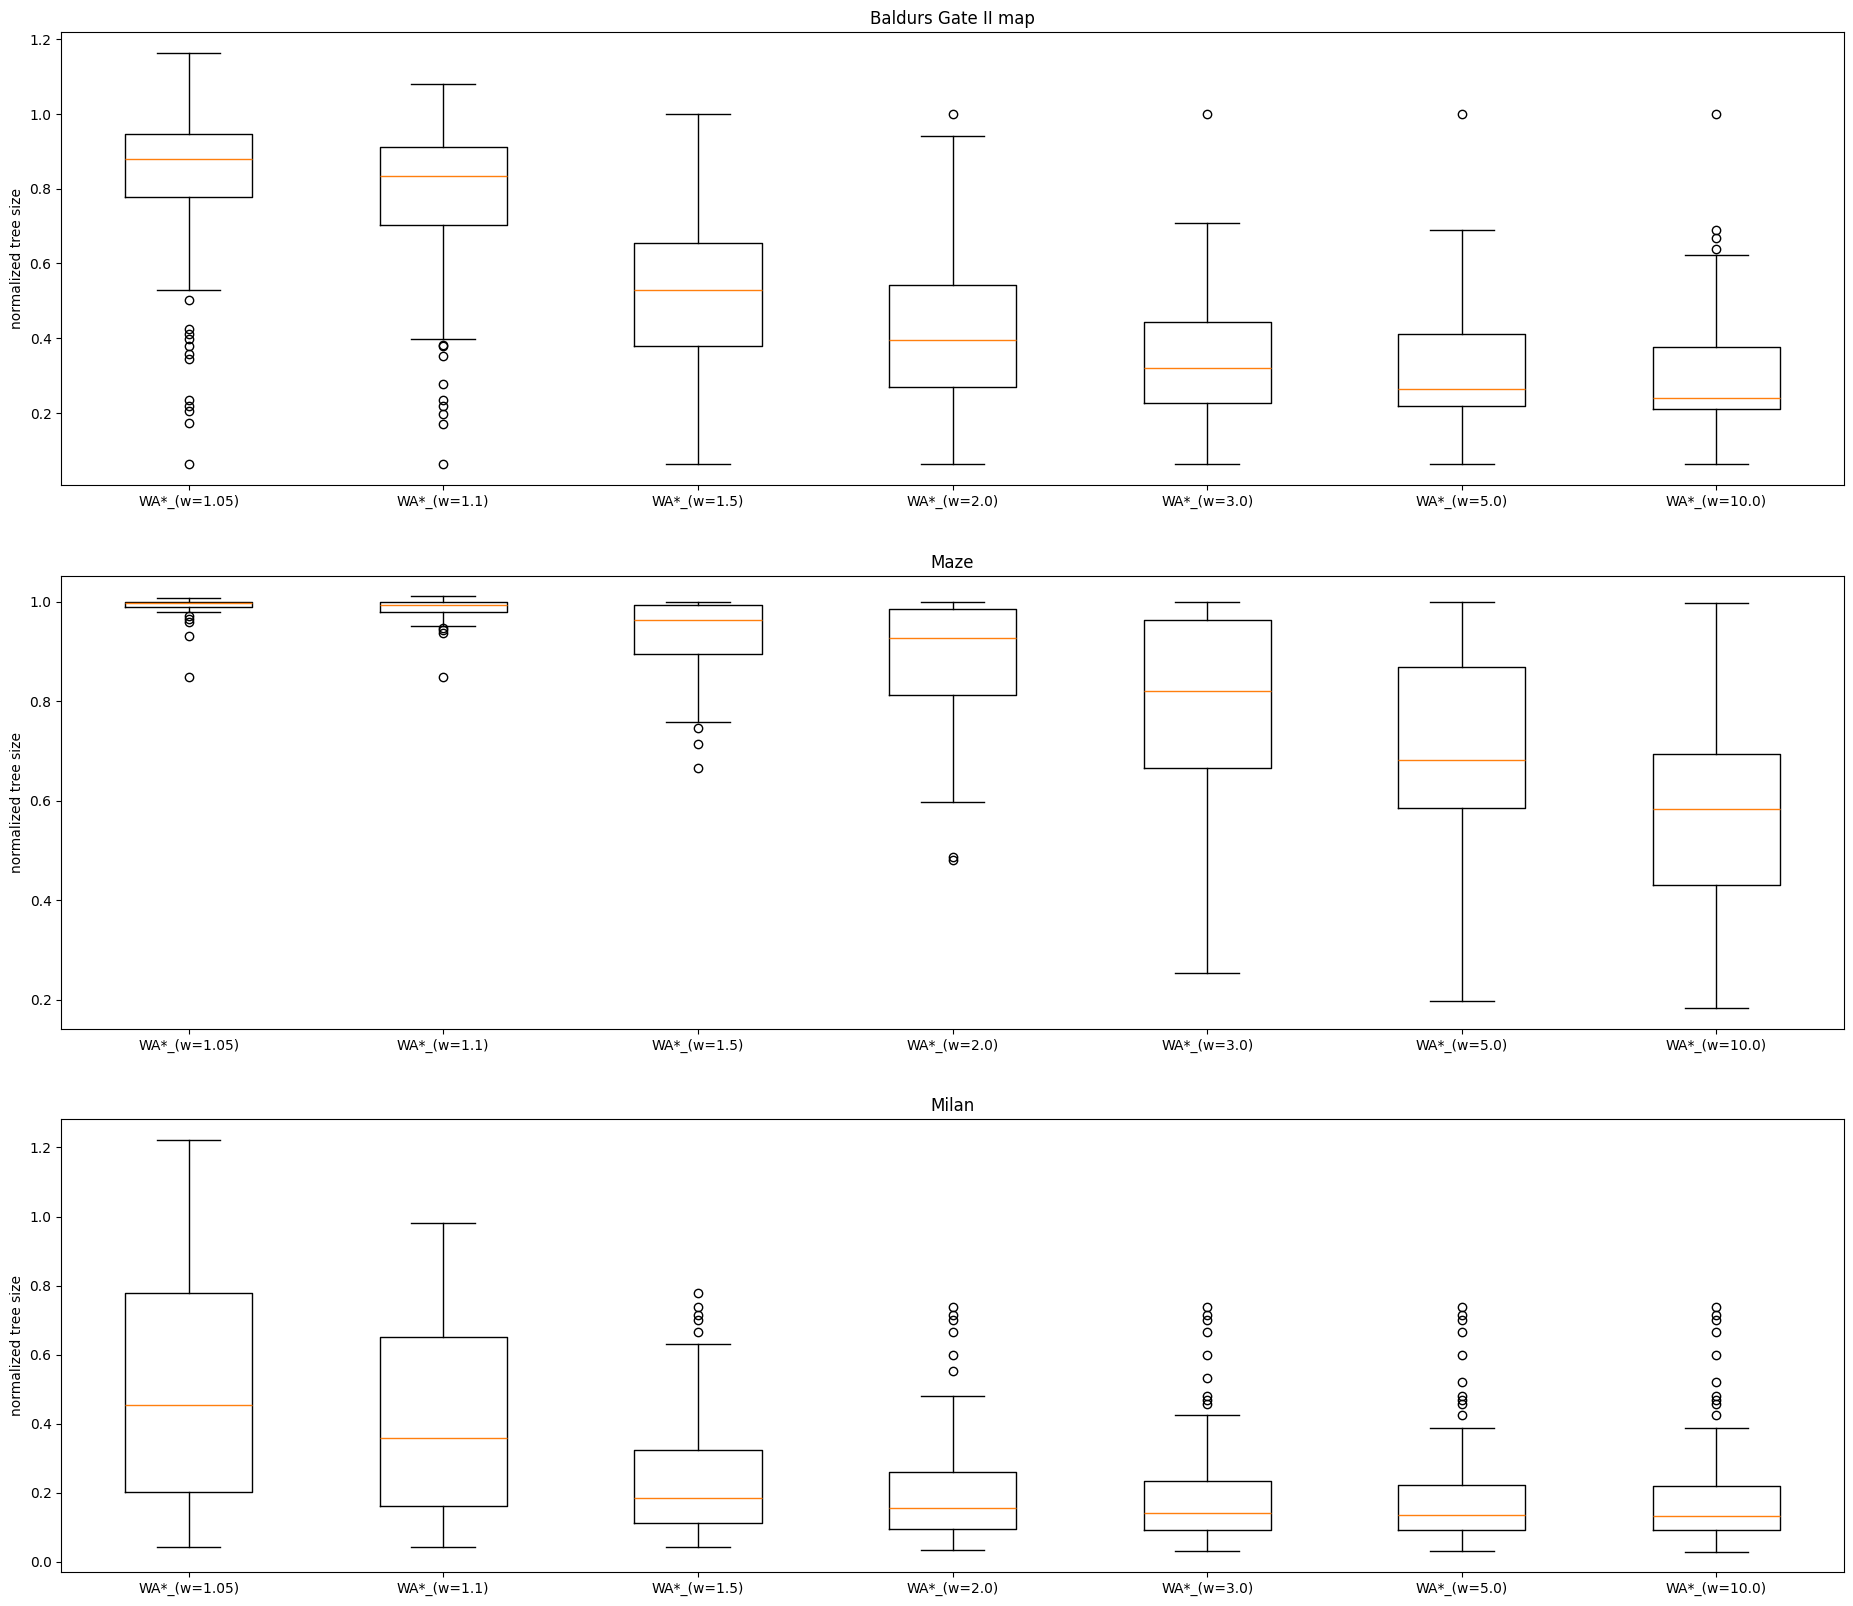

In [178]:
draw_box_plot(['tree size'])
draw_box_plot(['tree size'], True)

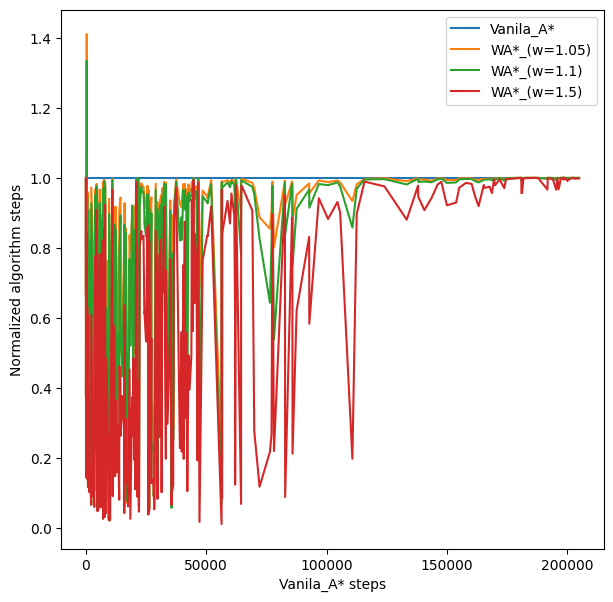

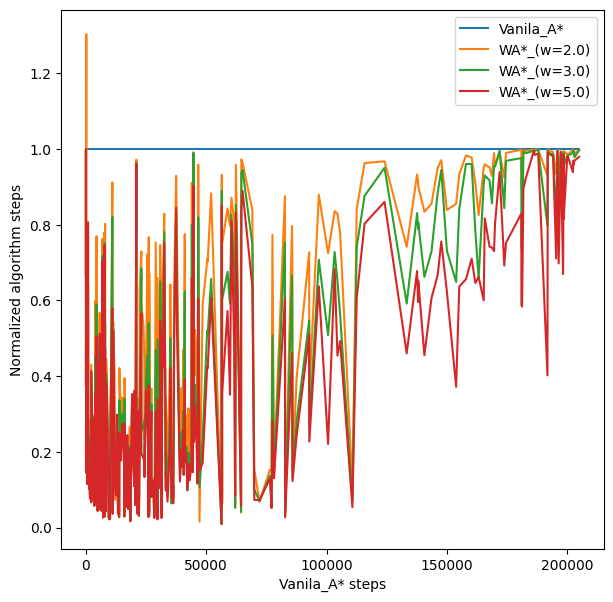

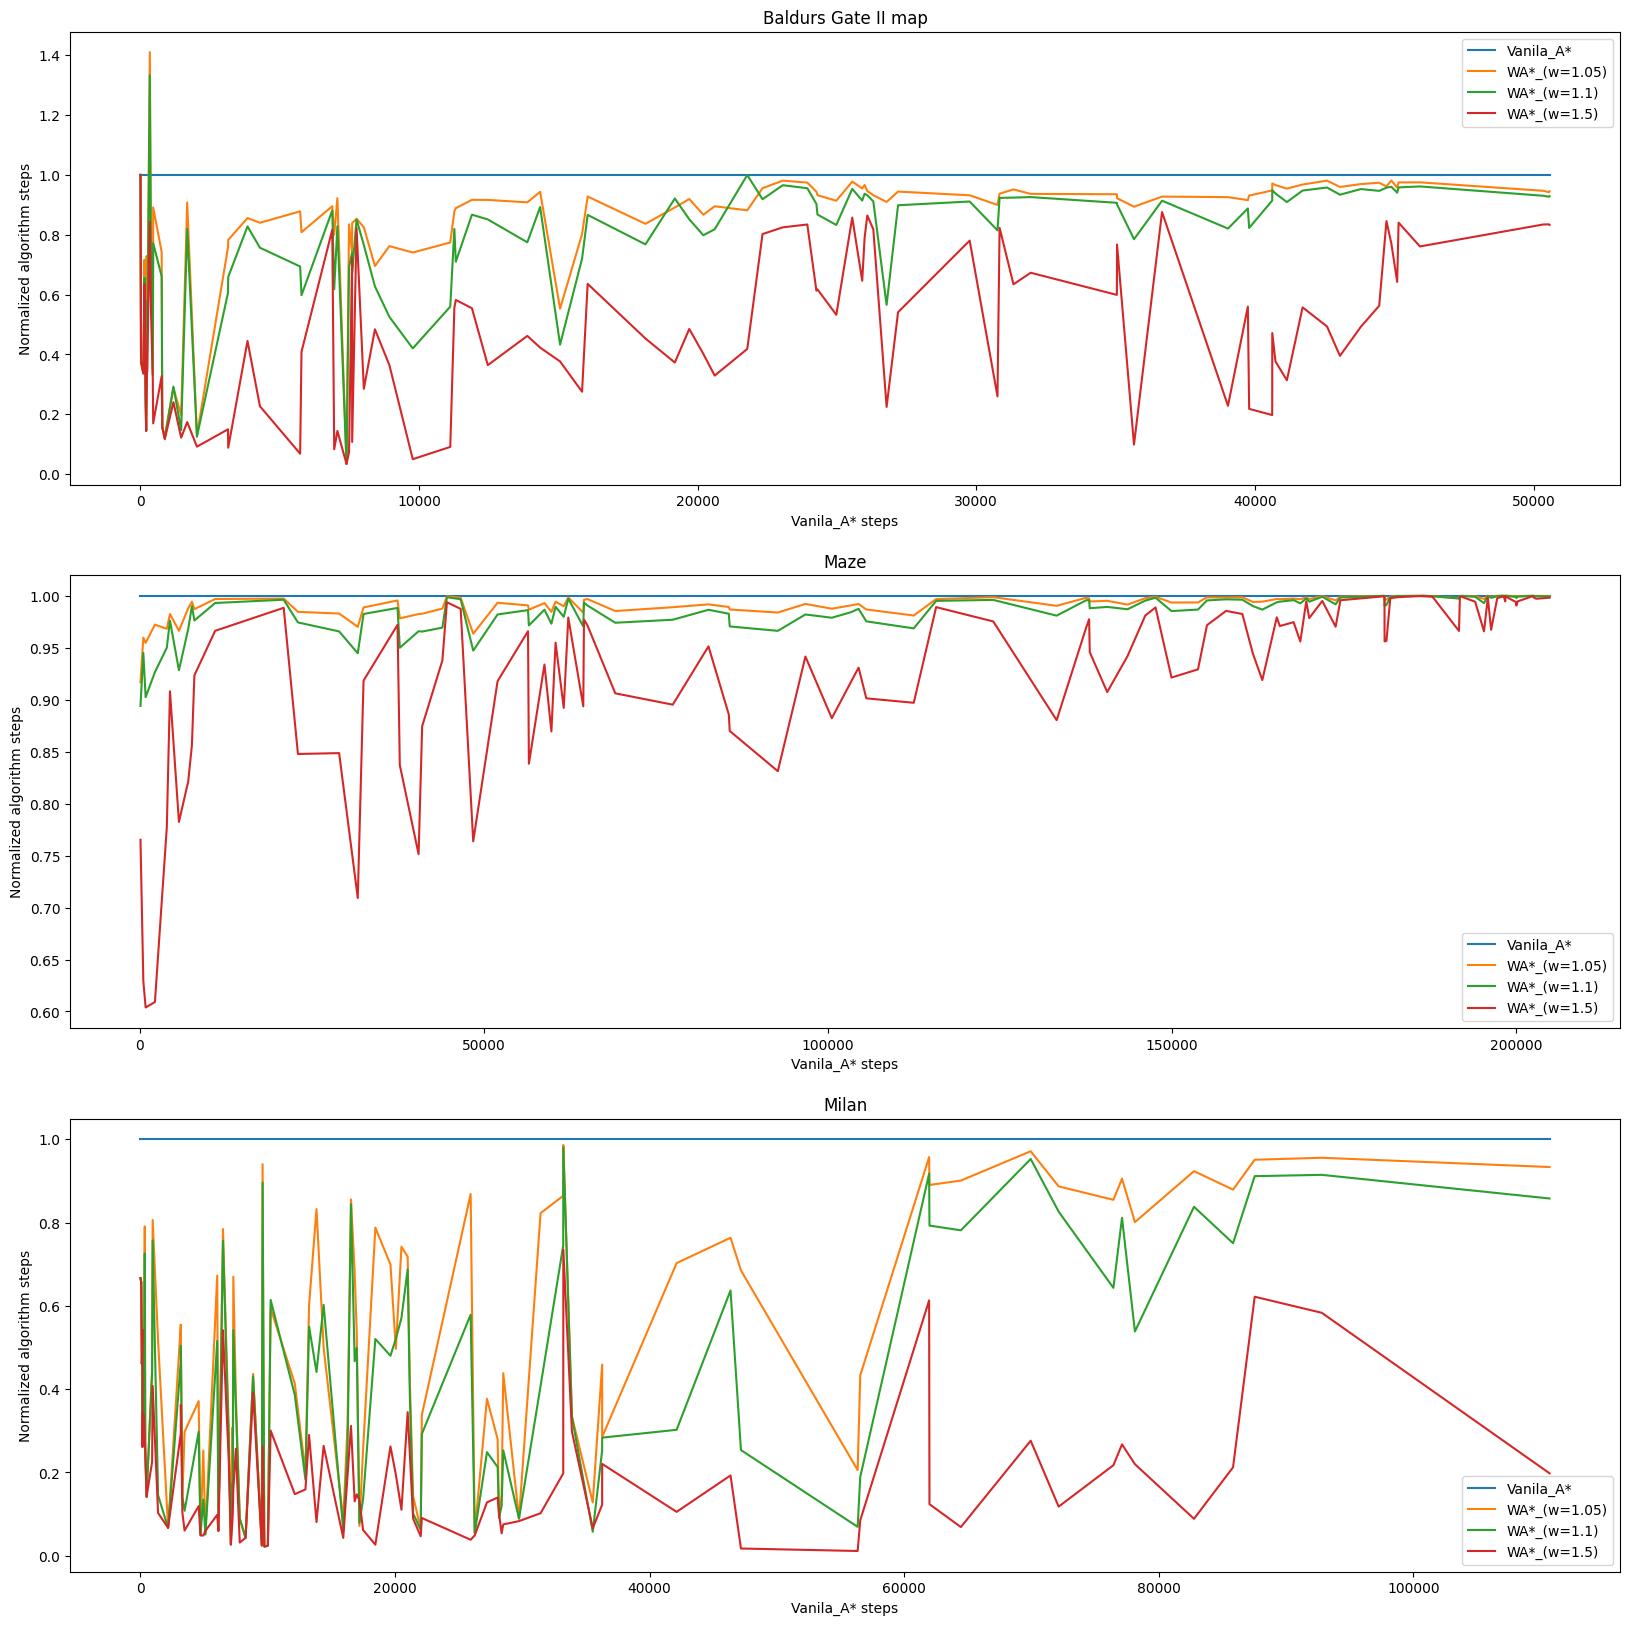

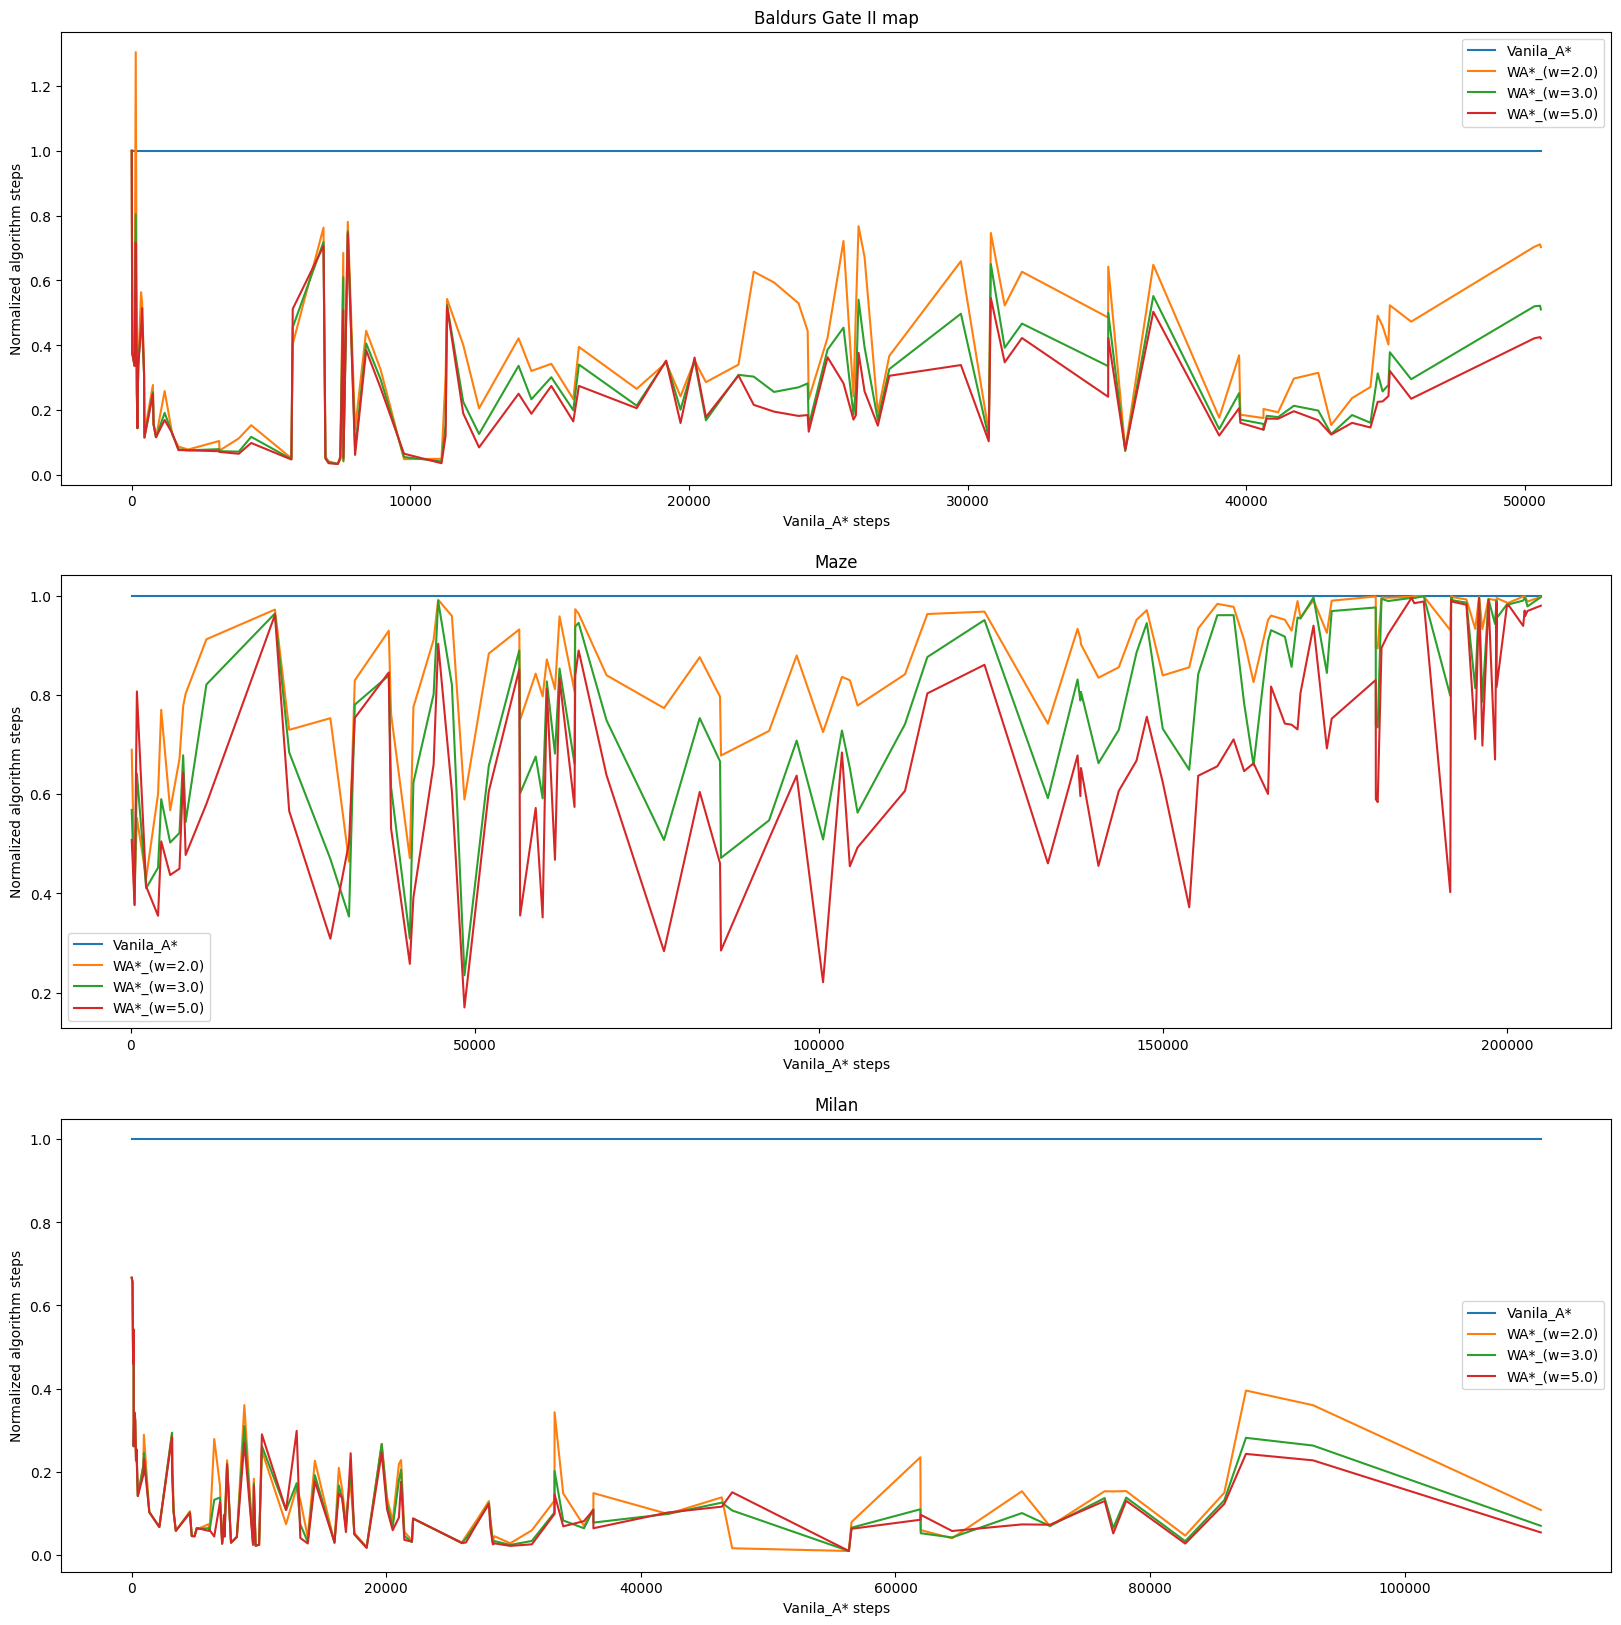

In [190]:
draw_plot('steps', [1.05, 1.1, 1.5])
draw_plot('steps', [2.0, 3.0, 5.0])
draw_plot_map('steps', [1.05, 1.1, 1.5])
draw_plot_map('steps', [2.0, 3.0, 5.0])

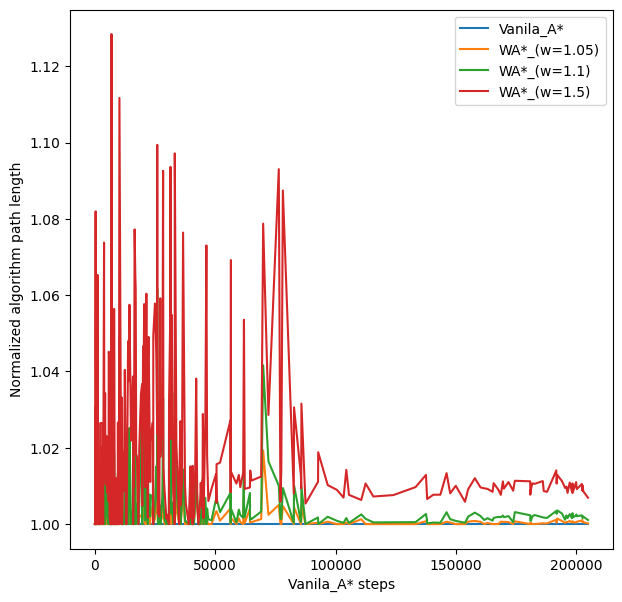

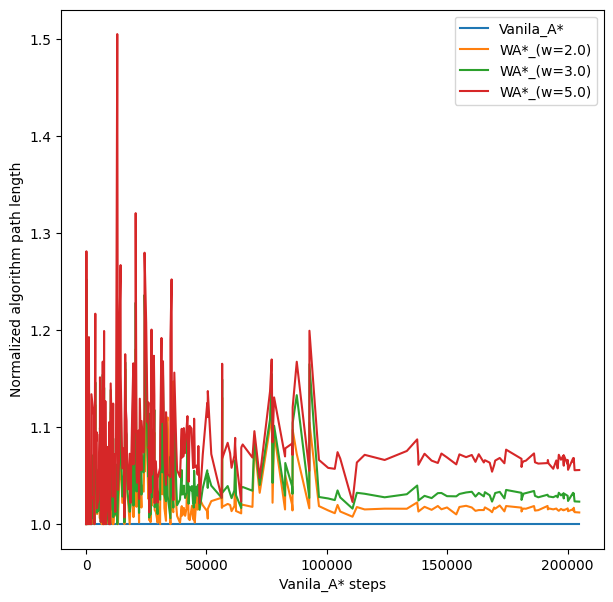

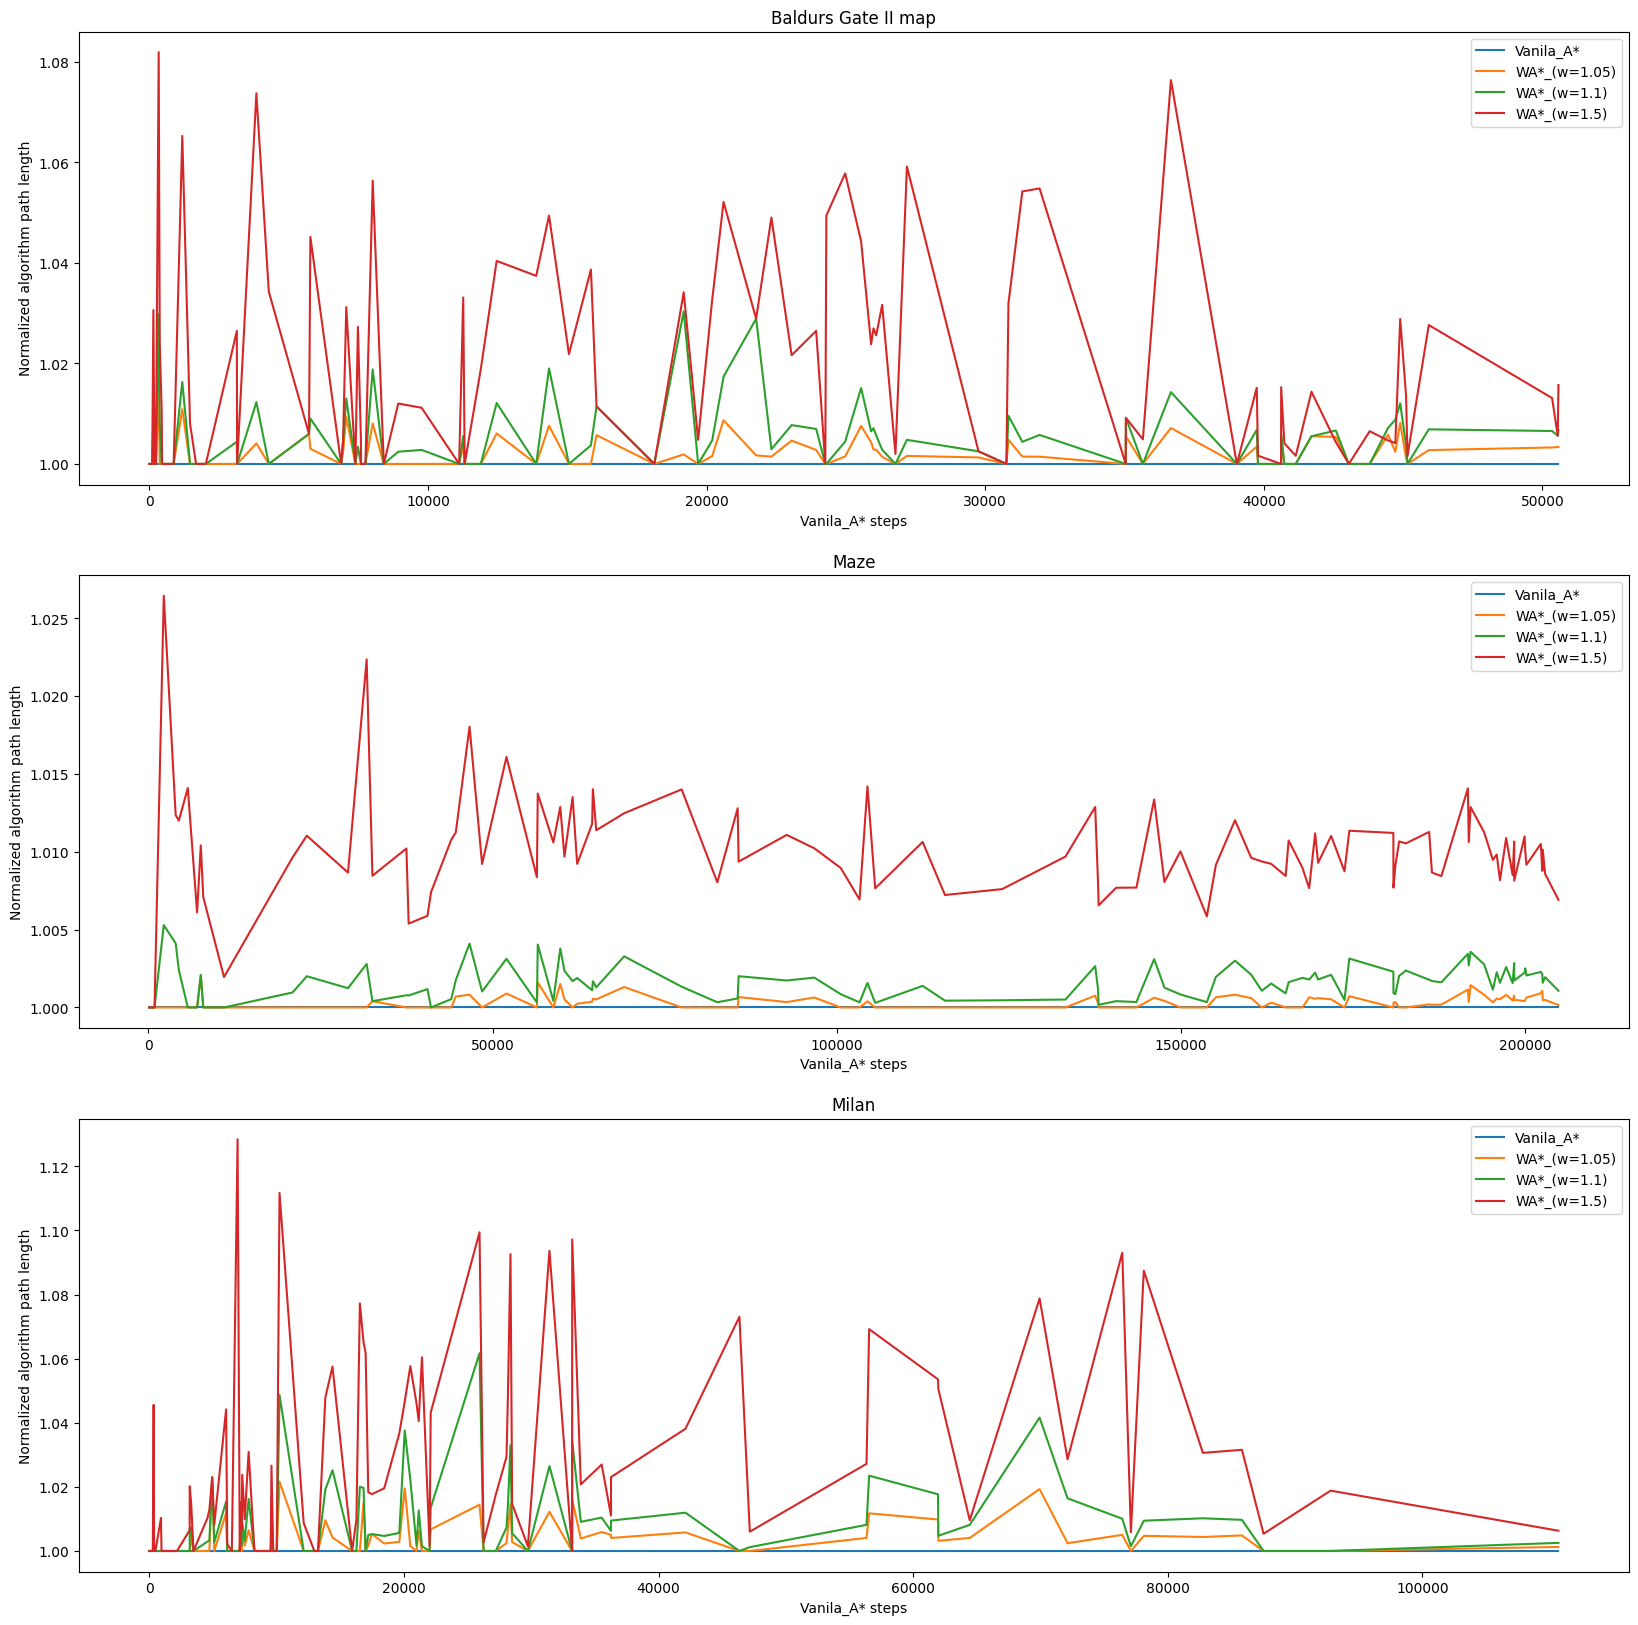

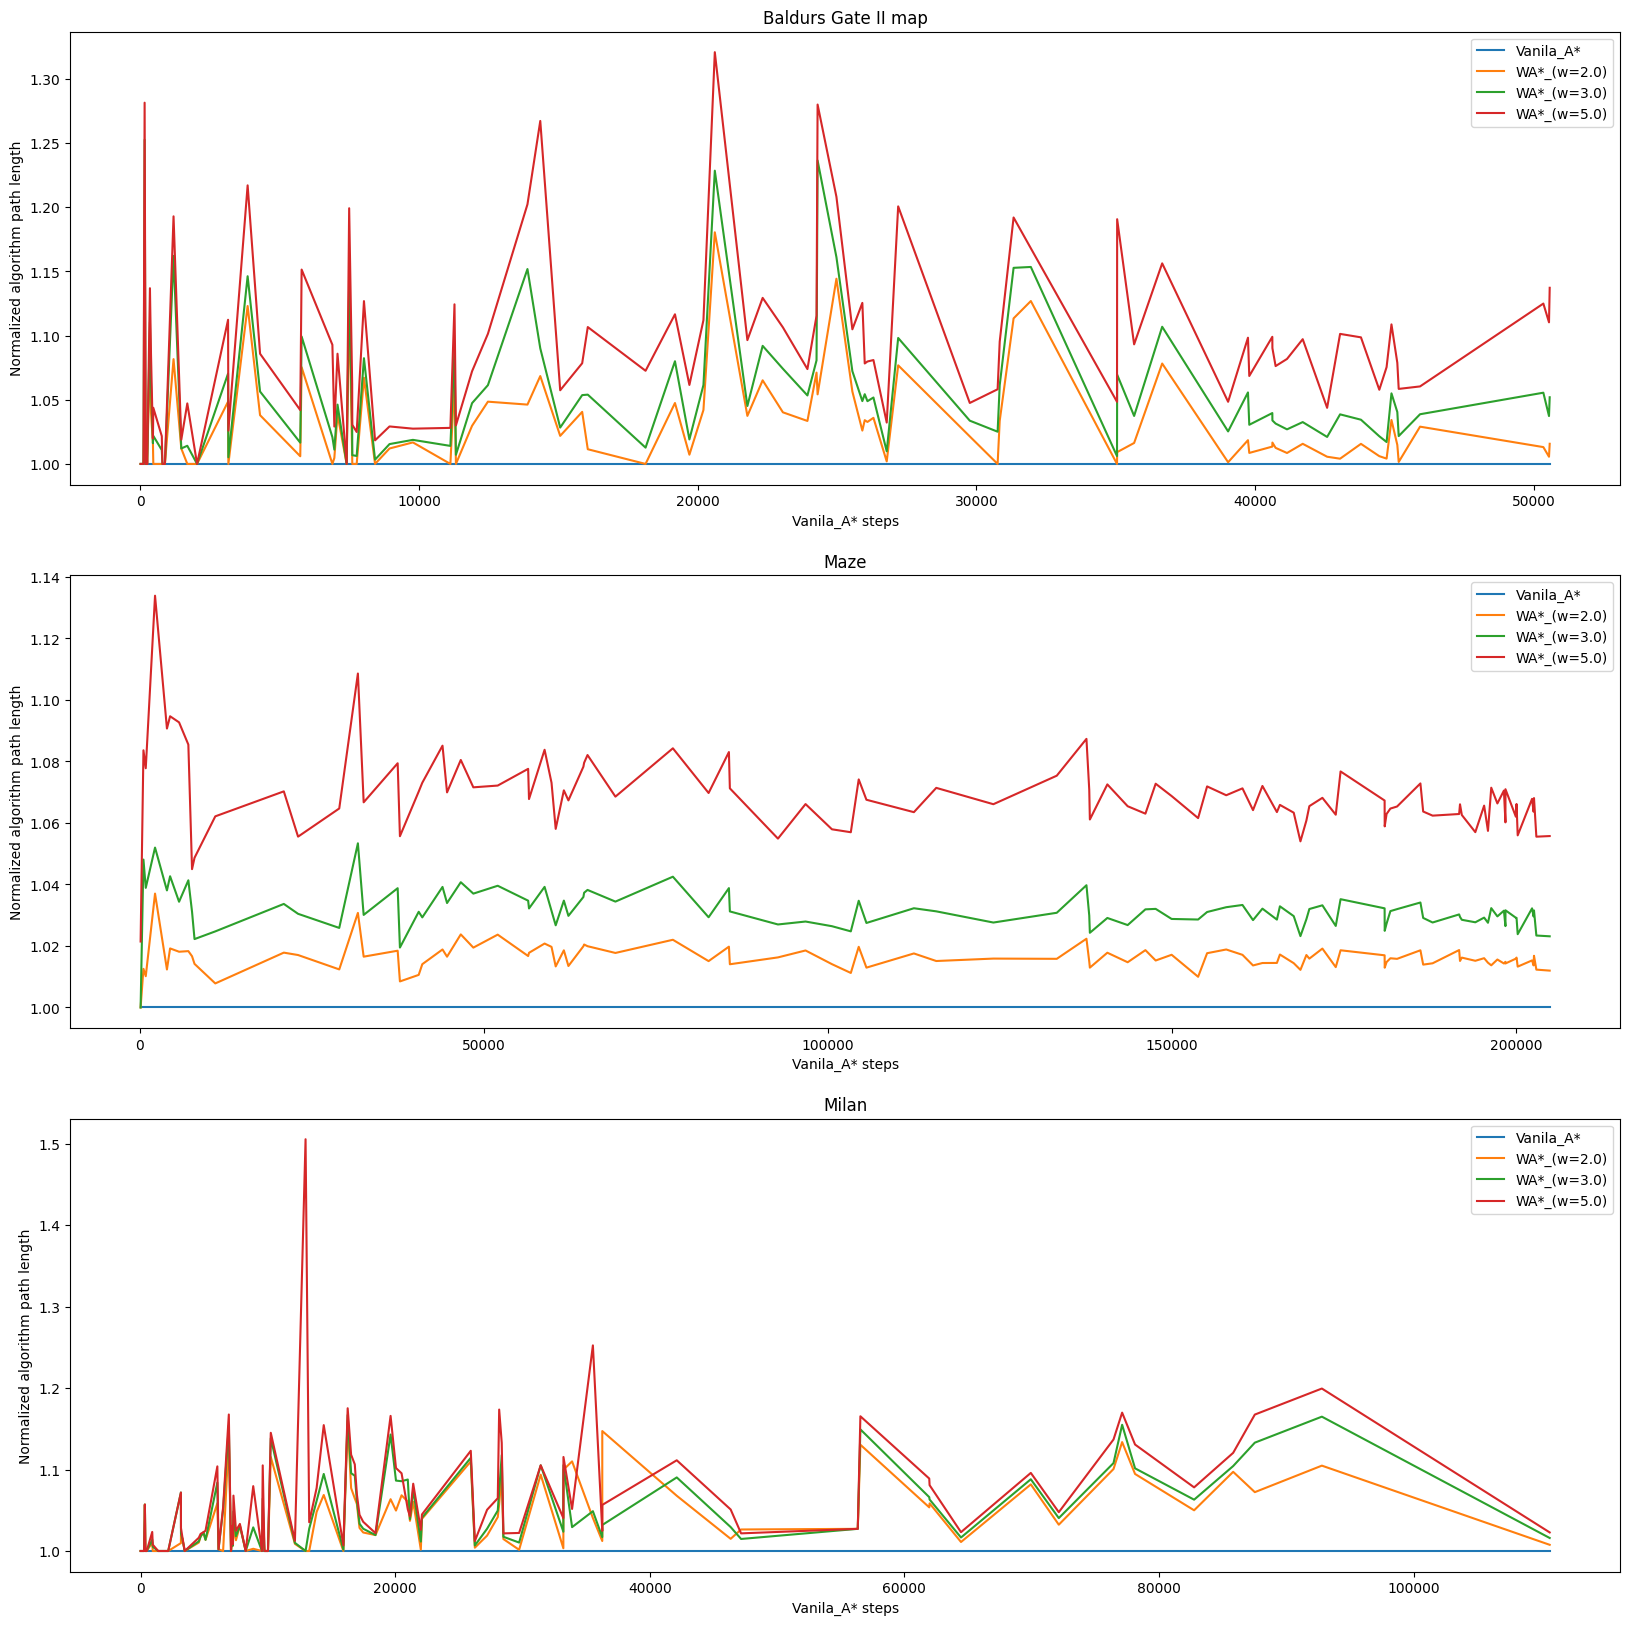

In [209]:
draw_plot('path length', [1.05, 1.1, 1.5])
draw_plot('path length', [2.0, 3.0, 5.0])
draw_plot_map('path length', [1.05, 1.1, 1.5])
draw_plot_map('path length', [2.0, 3.0, 5.0])

Посмотрим на tradeof между скоростью алгоритма (числом шагов) и увеличением длины пути. На следующем графике каждая точка представляет собой средние нормализованные значения данных величин. По оси X указана доля шагов алгоритма, относительно A*, по оси Y указано отношение длин путей между данным алгоритмом и A*. Около точки указано значение параметра w. Соответственно, в точке (1, 1) находится классический A*.

Как мы видим, точки располагаются на некоторой выпуклой кривой, нельзя сказать, что одно значение параметра лучше другого. Однако, средние значения (w = 2, w = 1.5) сочетают в себе ускорение работы почти в 2 раза и среднее увеличение пути примерно на 2%. Стоит также отметить, что даже незначительное увеличение параметра w по сравнению с классическим A* (w = 1.05) даёт незначительную ошибку, и сокращает время работы примерно на четверть. В то же время, большое значение параметра (w = 10) даёт значительное ускорение (время работы составляет примерно треть от ванильного варианта), но значение ошибки составляет примерно 10%, что довольно незначительно при таком ускорении.

Затем группа графиков представляет те же данные, но разбитые по картам. Как видим, тренд остаётся тем же, немного изменилось положение точек. На картах Baldurs Gate II и Милана ускорение больше, т.к. там лучше работает эвристика. Помимо этого, на карте Baldurs Gate II больше значение ошибки, т.к. там можно выбрать кардинально другой путь (в отличие от лабиринта) и получить значительную ошибку, если пройти по нему (в отличие от Милана, где есть достаточно пространства, чтобы сгладить ситуацию). 

Интересно также, что в лабиринте точки лежат примерно на одной прямой. Скорее всего это просто совпадение, т.к. здесь не может быть линейной зависимости (мы можем до бесконечности увеличивать значение параметра w, а число шагов ограничено нулём). Так что по всей видимости, эти точки попали на изгиб кривой, где они действительно лежат почти на одной прямой.

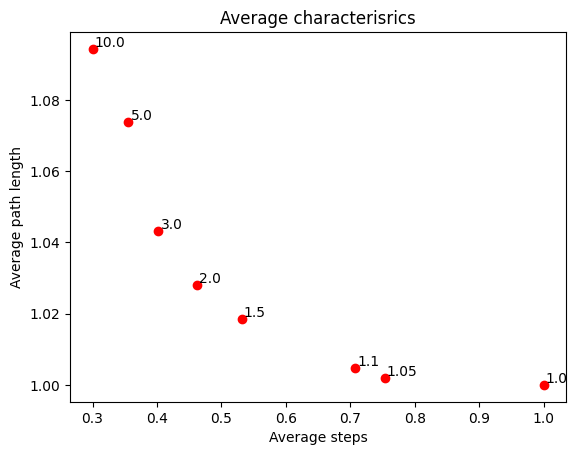

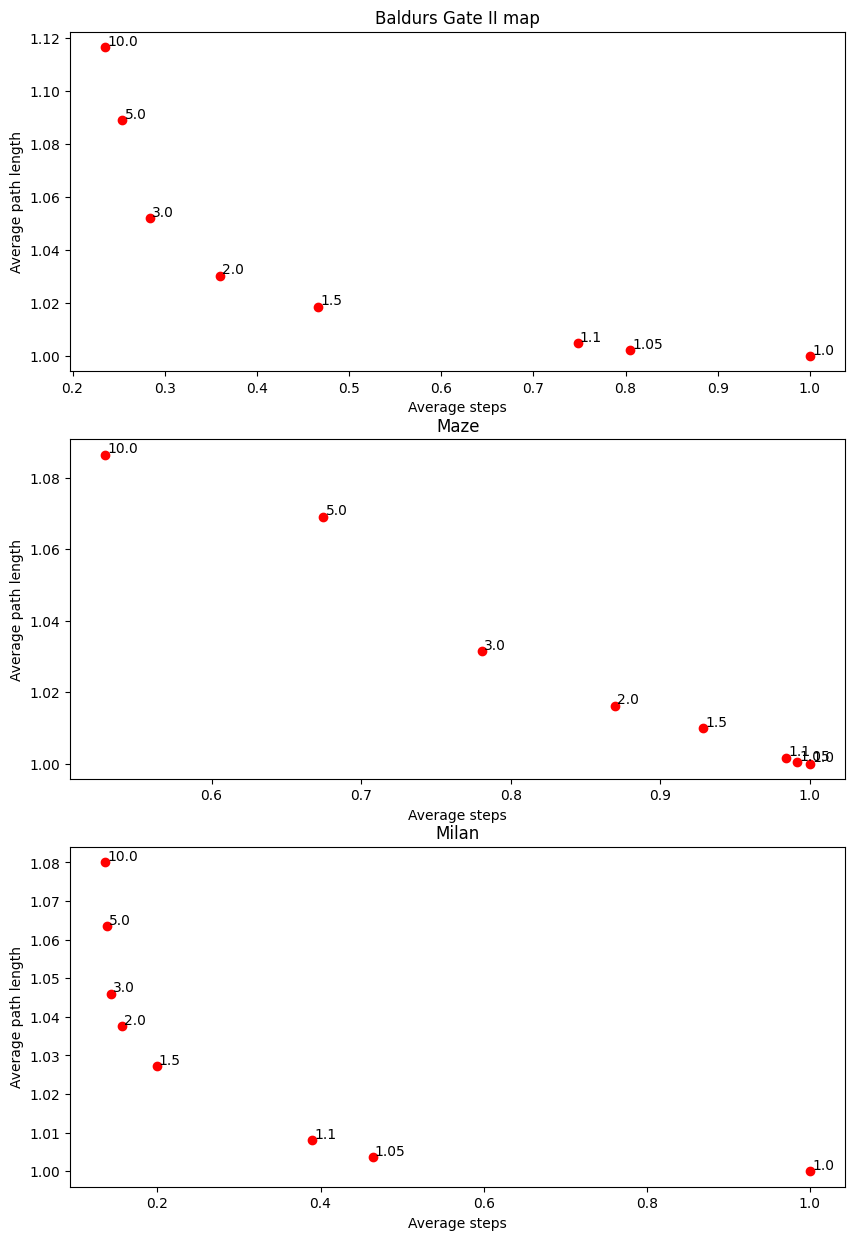

In [233]:
draw_points()
draw_map_points()

В данной работе были рассмотрены вариации алгоритма WA* с различными значениями параметра w, включая классический A*. На конкретной карте среднее значение отклонения в длине пути зависит от средней доли числа шагов примерно как гипербола. Её конкретная форма определяется топологией карты. Зачастую достаточно значения параметра w в диапазоне 1.5 - 2.0, чтобы получить значительное ускорение, и небольшую ошибку.